<a href="https://colab.research.google.com/github/alissonjcjk/Projeto-n-o-supervisionado-Machine-Learning-/blob/main/Projeto_N%C3%A3o_Supervisionado_Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Mini projeto Não Supervisionado
  O objetivo é construir um modelo baseado em K-Means e K-Prototypes para agrupar os passageiros do naufrágio do Titanic utilizando um banco de dados disponível na plaforma Kaggle.
Objetivos:
* Fazer uma EDA (Análise Exploratória dos Dados);
* Pré-processar/Tratar os dados, tornando-os adequados para o treinamento do modelo;
* Identificar o melhor valor K usando os métodos: Elbow, Calinski-Harabasz, Davies-Bouldin, Silhouette e BIC
* Rodar o modelo com o mlehor valor de K indicado e analisar algumas métricas, tais como da inércia, além de identificar características dos clusters


# Carregamento dos Dados

In [ ]:
!pip install -q kaggle

from google.colab import files
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

# ==============================================================================
# 1. CARREGAMENTO DOS DADOS
# ==============================================================================

files.upload()

!mkdir -p /root/.kaggle
!mv kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle competitions download -c titanic
!unzip -q titanic.zip

# Carrega o dataset
df = pd.read_csv('train.csv')

# --- MUDANÇA CRÍTICA: DESCARTANDO A COLUNA ALVO ---
if 'Survived' in df.columns:
    df.drop(columns=['Survived'], inplace=True)
    print("Coluna 'Survived' removida com sucesso.")

# Olhando as dimensões do dataset
print(f"Dimensões do dataset: {df.shape}")



Saving kaggle.json to kaggle.json
  0% 0.00/34.1k [00:00<?, ?B/s]
100% 34.1k/34.1k [00:00<00:00, 5.66MB/s]
Coluna 'Survived' removida com sucesso.
Dimensões do dataset: (891, 11)


#Análise Exploratória dos Dados (EDA) - Conhecendo o DataSet
A ideia dessa etapa é identificar as features e seus tipos, além de criar alguns gráficos de visualizações que fornecer um maior conhecimento do comportamento e das características de algumas variáveis, como dados faltantes ou inconsistentes. Isso é crucial para a tomada de algumas decisões na etapa de tratamento de dados.

In [ ]:
# Exibindo as primeiras linhas
display(df.head())

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
# Informações gerais (Tipos e Nulos)
print("\n--- INFO DO DATAFRAME ---")
df.info()


--- INFO DO DATAFRAME ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Pclass       891 non-null    int64  
 2   Name         891 non-null    object 
 3   Sex          891 non-null    object 
 4   Age          714 non-null    float64
 5   SibSp        891 non-null    int64  
 6   Parch        891 non-null    int64  
 7   Ticket       891 non-null    object 
 8   Fare         891 non-null    float64
 9   Cabin        204 non-null    object 
 10  Embarked     889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 76.7+ KB


In [ ]:
# Identifica variáveis
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = df.select_dtypes(include=['object']).columns
print(f"\nVariáveis Numéricas: {list(numeric_cols)}")
print(f"Variáveis Categóricas: {list(categorical_cols)}")


Variáveis Numéricas: ['PassengerId', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
Variáveis Categóricas: ['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']


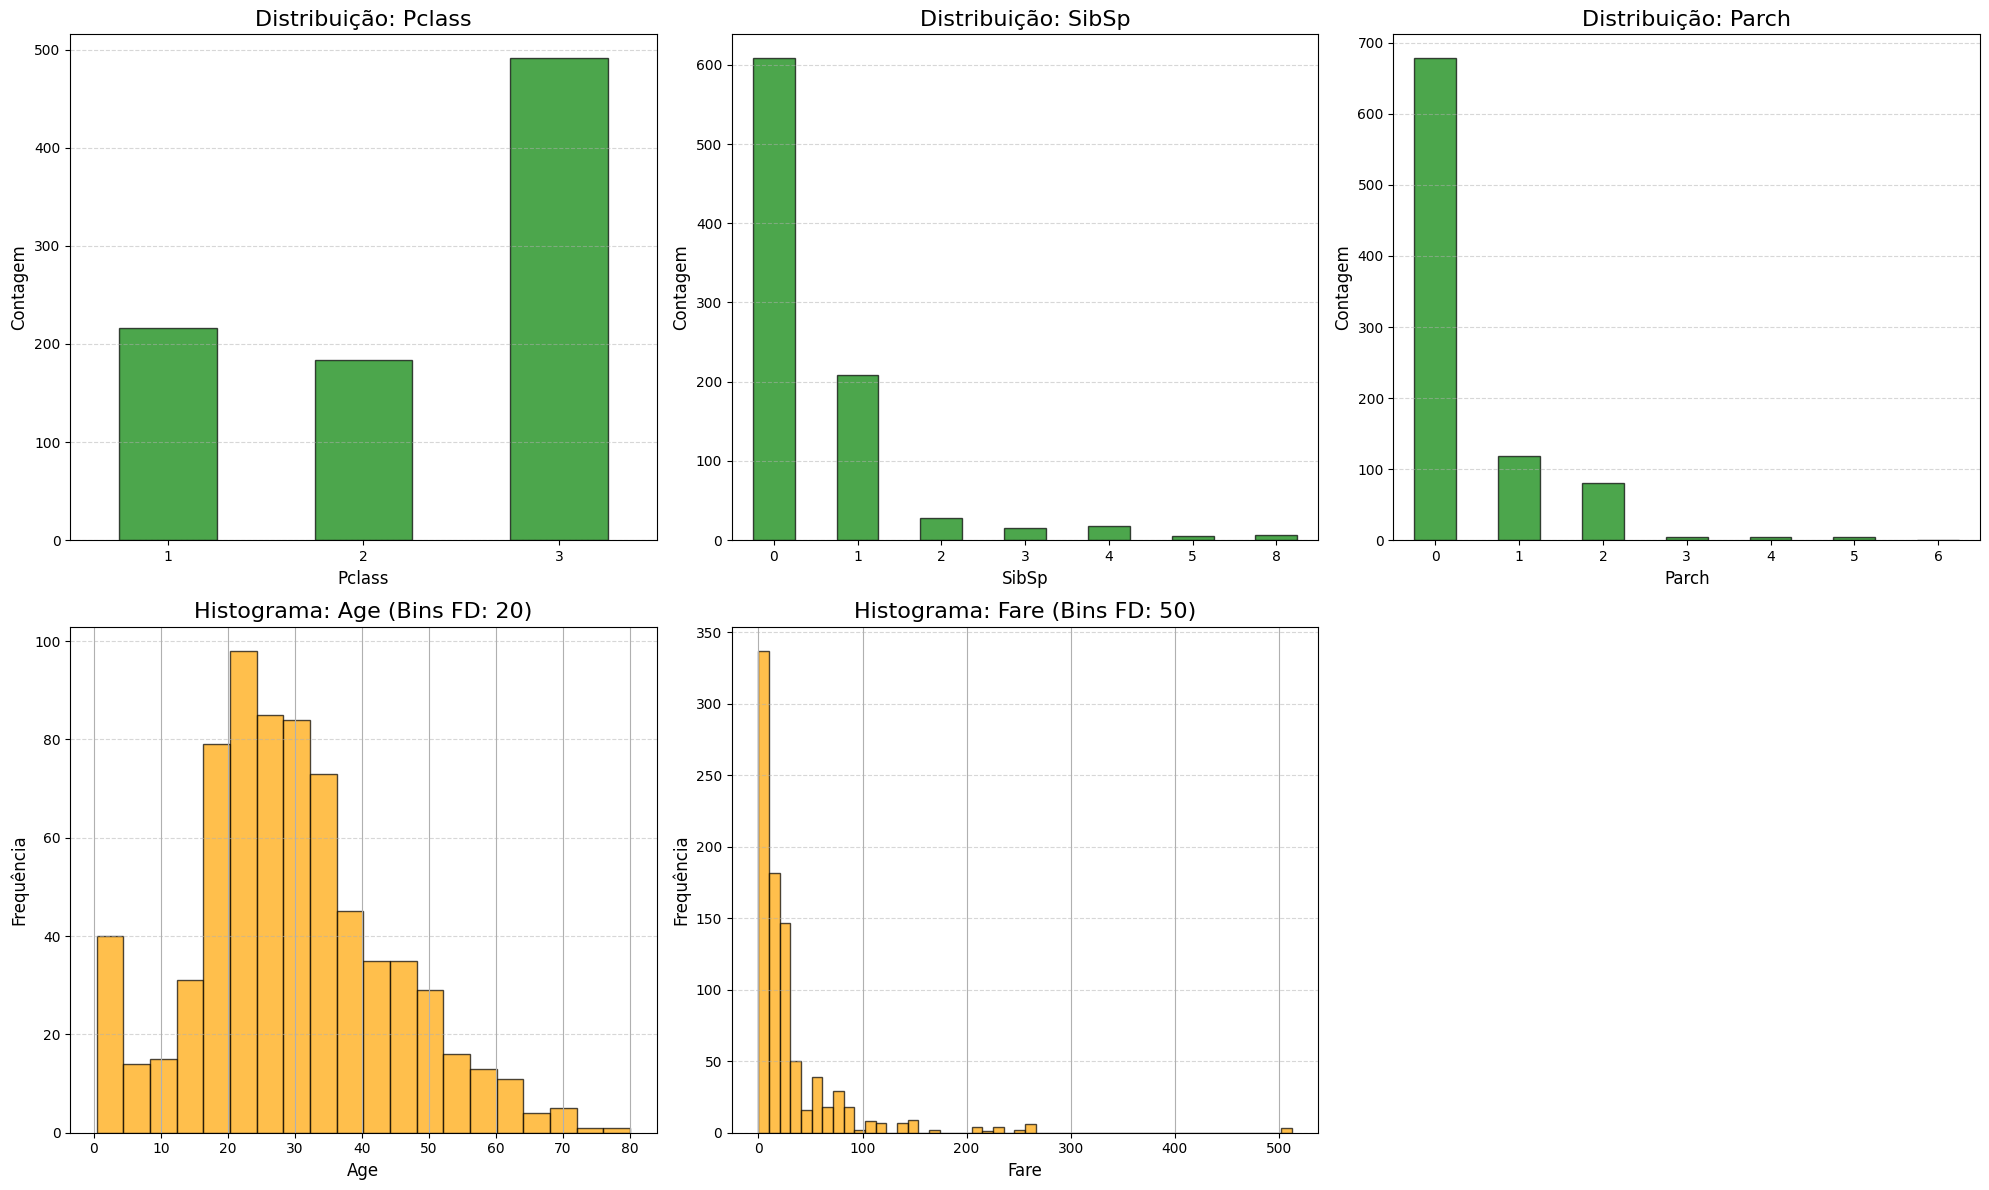

In [ ]:
# ==============================================================================
# 2. ANÁLISE EXPLORATÓRIA (EDA) - SEM A VARIÁVEL TARGET
# ==============================================================================


# --- PLOTAGEM DE DISTRIBUIÇÕES ---

# Definição das colunas para plotagem
# Removemos 'Survived' desta lista
discrete_features = ['Pclass', 'SibSp', 'Parch']
continuous_features = ['Age', 'Fare']

# Configuração do layout de plotagem
# Temos 3 discretas + 2 contínuas = 5 gráficos. O grid 2x3 (6 slots) funciona bem.
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 12))
axes = axes.flatten()

discrete_color = 'green'
continuous_color = 'orange'

# 1. Plotagem de Features Discretas (Gráfico de Barras)
for i, col in enumerate(discrete_features):
    ax = axes[i]
    df[col].value_counts().sort_index().plot(kind='bar', ax=ax, color=discrete_color, edgecolor='black', alpha=0.7)
    ax.set_title(f'Distribuição: {col}', fontsize=16)
    ax.set_xlabel(col, fontsize=12)
    ax.set_ylabel('Contagem', fontsize=12)
    ax.grid(axis='y', linestyle='--', alpha=0.5)
    ax.tick_params(axis='x', rotation=0)

# 2. Plotagem de Features Contínuas (Histogramas com Bins Freedman-Diaconis)
# O índice inicial é len(discrete_features) para continuar nos próximos subplots
for i, col in enumerate(continuous_features):
    ax = axes[i + len(discrete_features)]

    data = df[col].dropna()
    n = len(data)

    # Cálculo do IQR para a Regra Freedman-Diaconis
    Q3, Q1 = np.percentile(data, [75 ,25])
    feature_iqr = Q3 - Q1

    if feature_iqr == 0 or n <= 1:
        num_bins = 10
    else:
        bin_width = 2 * feature_iqr * (n ** (-1/3))
        if bin_width > 0:
            num_bins = int(np.ceil((data.max() - data.min()) / bin_width))
        else:
            num_bins = 10

        # Travas de segurança para visualização
        num_bins = max(5, min(50, num_bins))

    df[col].hist(bins=num_bins, ax=ax, color=continuous_color, edgecolor='black', alpha=0.7)
    ax.set_title(f'Histograma: {col} (Bins FD: {num_bins})', fontsize=16)
    ax.set_xlabel(col, fontsize=12)
    ax.set_ylabel('Frequência', fontsize=12)
    ax.grid(axis='y', linestyle='--', alpha=0.5)

# Remove o último subplot vazio (se houver, já que 2x3=6 e temos 5 gráficos)
if len(discrete_features) + len(continuous_features) < len(axes):
    fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()

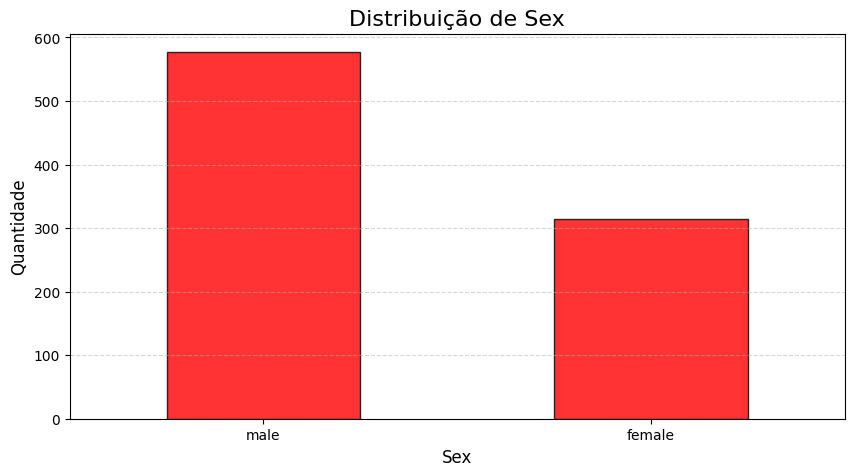

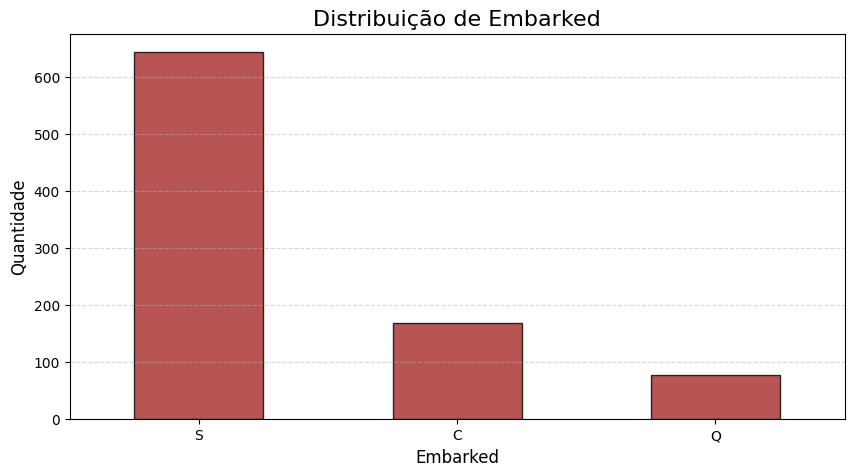

In [ ]:
# --- PLOTAGEM DE CATEGÓRICAS (Sex, Embarked) ---
# Aqui vemos apenas a contagem bruta, sem relação com sobrevivência
categorical_features_plot = ['Sex', 'Embarked']
colors = ['red', 'brown']

for col, color in zip(categorical_features_plot, colors):
    if col in df.columns: # Checagem de segurança
        plt.figure(figsize=(10, 5))
        counts = df[col].value_counts()
        counts.plot(kind='bar', color=color, edgecolor='black', alpha=0.8)
        plt.title(f'Distribuição de {col}', fontsize=16)
        plt.xlabel(col, fontsize=12)
        plt.ylabel('Quantidade', fontsize=12)
        plt.grid(axis='y', linestyle='--', alpha=0.5)
        plt.xticks(rotation=0)
        plt.show()


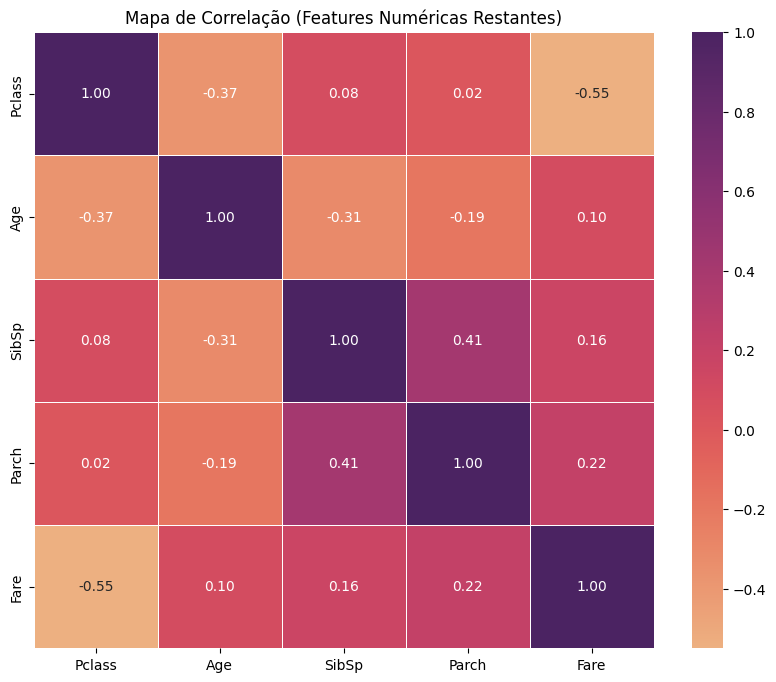

In [ ]:

# --- MAPA DE CORRELAÇÃO (Features Numéricas) ---
# Importante para ver multicolinearidade antes do K-Means
numeric_df = df.select_dtypes(include=['number'])
# Remove PassengerId se existir, pois não é feature preditiva/descritiva
if 'PassengerId' in numeric_df.columns:
    numeric_df = numeric_df.drop(columns=['PassengerId'])

corr_matrix = numeric_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='flare', linewidths=0.5, fmt=".2f")
plt.title('Mapa de Correlação (Features Numéricas Restantes)')
plt.show()

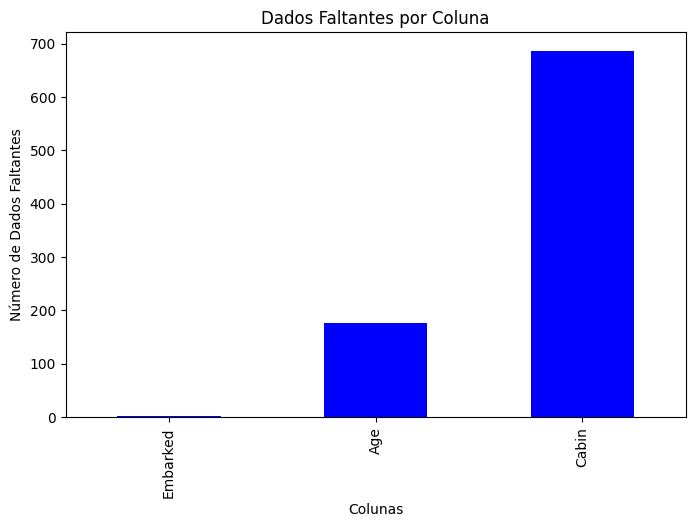

In [ ]:
# --- ANÁLISE DE DADOS FALTANTES ---
faltando = df.isnull().sum()
faltando = faltando[faltando > 0]
faltando.sort_values(inplace=True)

if not faltando.empty:
    faltando.plot.bar(color='b', figsize=(8, 5))
    plt.xlabel('Colunas')
    plt.ylabel('Número de Dados Faltantes')
    plt.title('Dados Faltantes por Coluna')
    plt.show()
else:
    print("Não há dados faltantes nas colunas carregadas.")

#Tratamento dos Dados

1- Preenche os valores faltantes usando a mediana para Age e moda para Embarked;

2- Remove as colunas PassagenrID; Ticket; Name;

3- Aplica one hot encodign em Sex; Embarked; Pclass

4- Para a feature cabin, considera como 0 quando tem valor faltante e 1 quando tem o número da cabine

5- Normaliza as features numéricas




In [ ]:
from sklearn.preprocessing import MinMaxScaler

print("--- INICIANDO PRÉ-PROCESSAMENTO PARA K-MEANS ---")

# 1. TRATAMENTO DE VALORES FALTANTES
# ==============================================================================
# Age: Preencher com a Mediana
mediana_age = df['Age'].median()
df['Age'].fillna(mediana_age, inplace=True)
print(f"Age: Nulos preenchidos com a mediana ({mediana_age})")

# Embarked: Preencher com a Moda
moda_embarked = df['Embarked'].mode()[0]
df['Embarked'].fillna(moda_embarked, inplace=True)
print(f"Embarked: Nulos preenchidos com a moda ('{moda_embarked}')")

# 2. ENGENHARIA DE FEATURE: CABIN
# ==============================================================================
# 0 se for nulo, 1 se tiver valor (transforma em binário)
# O .notna() retorna True/False, o .astype(int) vira 1/0
df['Cabin'] = df['Cabin'].notna().astype(int)
print("Cabin: Transformada em binária (1=Com Cabine, 0=Sem Cabine)")

# 3. REMOÇÃO DE COLUNAS DESNECESSÁRIAS
# ==============================================================================
cols_to_drop = ['PassengerId', 'Name', 'Ticket']
# Verifica se a coluna existe antes de dropar para evitar erro caso rode a célula 2x
cols_present = [c for c in cols_to_drop if c in df.columns]
df.drop(columns=cols_present, inplace=True)
print(f"Colunas removidas: {cols_present}")

# 4. ONE-HOT ENCODING (Sex, Embarked, Pclass)
# ==============================================================================
# Primeiro, converte Pclass para string para o get_dummies entender como categoria
df['Pclass'] = df['Pclass'].astype(str)

cols_to_encode = ['Sex', 'Embarked', 'Pclass']

# drop_first=False: Cria colunas para TODAS as categorias.
# No K-Means, isso ajuda a calcular distâncias simétricas.
df = pd.get_dummies(df, columns=cols_to_encode, drop_first=False)

# Garante que as novas colunas sejam numéricas (0 e 1) e não booleanas
# (Dependendo da versão do pandas, get_dummies pode retornar True/False)
df = df.astype(int) # Converte tudo para int temporariamente (Age/Fare voltam a float na normalização)
# Reverter Age e Fare para float para não perder precisão decimal antes da normalização
df['Age'] = df['Age'].astype(float)
df['Fare'] = df['Fare'].astype(float)

print(f"Encoding aplicado. Novas colunas: {list(df.columns)}")


# 5. NORMALIZAÇÃO SELETIVA (Apenas features contínuas/numéricas não-binárias)
# ==============================================================================

# Lista explicita do que precisa ser normalizado
# Cabin já é 0/1. As One-Hot (Sex_*, Embarked_*, Pclass_*) já são 0/1.
cols_to_normalize = ['Age', 'Fare', 'SibSp', 'Parch']

print(f"Normalizando apenas: {cols_to_normalize}")

scaler = MinMaxScaler()

# Aplica apenas nessas colunas
df[cols_to_normalize] = scaler.fit_transform(df[cols_to_normalize])

print("\n--- DATASET FINAL PRONTO PARA K-MEANS ---")
print(f"Shape final: {df.shape}")
display(df.head())

# Verificação: As colunas One-Hot devem continuar como inteiros (0/1)
# enquanto Age/Fare estarão float entre 0 e 1.
# print("\nVerificação de Tipos e Escala:")
# display(df.describe().loc[['min', 'max']])

--- INICIANDO PRÉ-PROCESSAMENTO PARA K-MEANS ---
Age: Nulos preenchidos com a mediana (28.0)
Embarked: Nulos preenchidos com a moda ('S')
Cabin: Transformada em binária (1=Com Cabine, 0=Sem Cabine)
Colunas removidas: ['PassengerId', 'Name', 'Ticket']
Encoding aplicado. Novas colunas: ['Age', 'SibSp', 'Parch', 'Fare', 'Cabin', 'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Pclass_1', 'Pclass_2', 'Pclass_3']
Normalizando apenas: ['Age', 'Fare', 'SibSp', 'Parch']

--- DATASET FINAL PRONTO PARA K-MEANS ---
Shape final: (891, 13)


/tmp/ipython-input-2074377358.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Age'].fillna(mediana_age, inplace=True)
/tmp/ipython-input-2074377358.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 

,Age,SibSp,Parch,Fare,Cabin,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3
0,0.2750,0.125,0.0,0.013672,0,0,1,0,0,1,0,0,1
1,0.4750,0.125,0.0,0.138672,1,1,0,1,0,0,1,0,0
2,0.3250,0.000,0.0,0.013672,0,1,0,0,0,1,0,0,1
3,0.4375,0.125,0.0,0.103516,1,1,0,0,0,1,1,0,0
4,0.4375,0.000,0.0,0.015625,0,0,1,0,0,1,0,0,1


Calculando métricas para diferentes valores de K (aguarde)...

--- VOTAÇÃO DOS MÉTODOS ---
1. Silhouette Score: K = 10 (Quanto maior, melhor)
2. Calinski-Harabasz: K = 10 (Quanto maior, melhor)
3. Davies-Bouldin:    K = 10 (Quanto menor, melhor)
4. Elbow (KneeLocator): K = 4 (Ponto de inflexão)

>>> VALOR DE K ESCOLHIDO (MAIORIA): 10


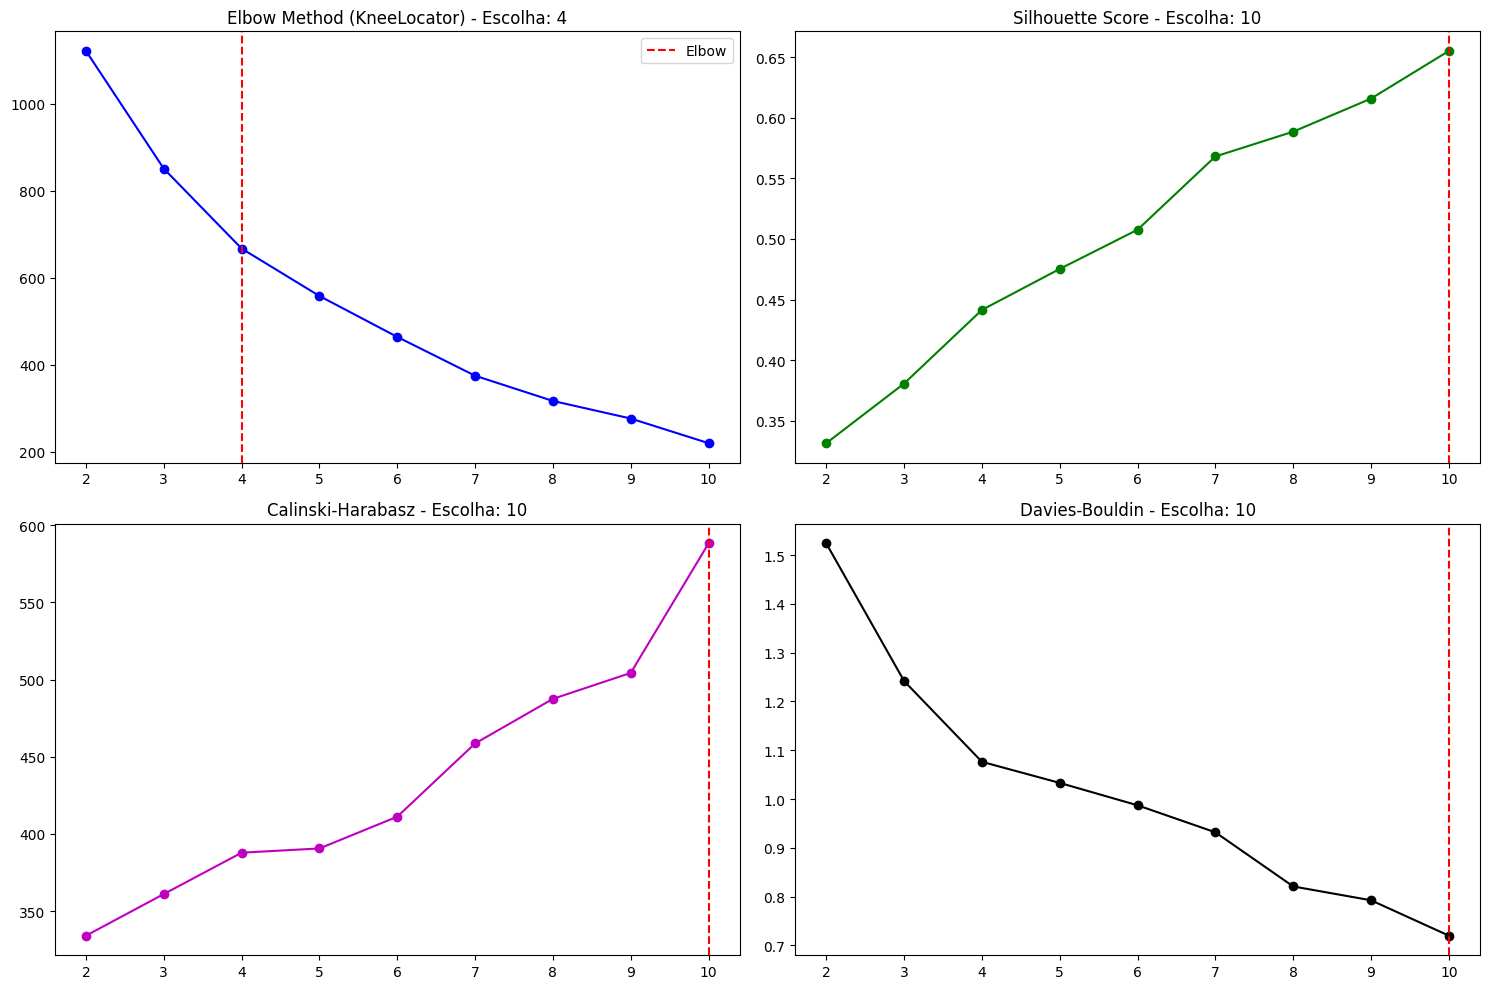

EXECUTANDO K-MEANS FINAL COM K=10
Parâmetros: n_init=100, max_iter=300

--- ATRIBUTOS FINAIS ---

1. Inércia Final: 220.1756
2. Número de iterações: 4

3. Centroides dos Clusters (Cluster Centers):


,Age,SibSp,Parch,Fare,Cabin,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3
Cluster,,,,,,,,,,,,,
0,0.298438,0.154830,0.166667,0.035445,5.681818e-02,1.000000e+00,-1.332268e-15,5.551115e-17,-1.526557e-16,1.000000e+00,1.665335e-16,0.000000e+00,1.000000e+00
1,0.294764,0.045608,0.065315,0.024599,2.498002e-16,2.972973e-01,7.027027e-01,1.000000e+00,-1.110223e-16,9.992007e-16,1.665335e-16,1.216216e-01,8.783784e-01
2,0.412745,0.073529,0.098039,0.190794,9.019608e-01,1.000000e+00,-8.881784e-16,0.000000e+00,1.960784e-02,9.803922e-01,1.000000e+00,2.775558e-17,-1.110223e-16
3,0.341146,0.052083,0.030093,0.020616,1.388889e-02,4.583333e-01,5.416667e-01,0.000000e+00,1.000000e+00,9.992007e-16,1.942890e-16,5.551115e-17,1.000000e+00
4,0.480682,0.034091,0.053030,0.177956,7.500000e-01,0.000000e+00,1.000000e+00,9.772727e-01,2.272727e-02,-3.330669e-16,9.772727e-01,2.272727e-02,-1.110223e-16
5,0.490506,0.041139,0.042194,0.102774,7.974684e-01,-7.216450e-16,1.000000e+00,0.000000e+00,-1.249001e-16,1.000000e+00,1.000000e+00,0.000000e+00,7.771561e-16
6,0.359667,0.061667,0.102222,0.042760,1.200000e-01,1.000000e+00,-1.221245e-15,8.000000e-02,2.666667e-02,8.933333e-01,1.665335e-16,1.000000e+00,5.551115e-16
7,0.335472,0.066038,0.042138,0.025029,1.886792e-02,-1.332268e-15,1.000000e+00,1.193490e-15,-2.775558e-16,1.000000e+00,1.942890e-16,-1.443290e-15,1.000000e+00
8,0.433611,0.063889,0.051852,0.216493,8.222222e-01,1.000000e+00,-8.881784e-16,1.000000e+00,4.163336e-17,-4.440892e-16,9.555556e-01,2.222222e-02,2.222222e-02


In [ ]:
!pip install -q kneed

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from collections import Counter
from kneed import KneeLocator # <--- NOVA IMPORTAÇÃO

# ==============================================================================
# 1. CÁLCULO DAS MÉTRICAS (K=2 a K=10)
# ==============================================================================
print("Calculando métricas para diferentes valores de K (aguarde)...")

inertias = []
silhouettes = []
calinski = []
davies = []

K_range = range(2, 11) # Testando de 2 a 10 clusters

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=100, init="random")
    kmeans.fit(df)
    labels = kmeans.labels_

    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(df, labels))
    calinski.append(calinski_harabasz_score(df, labels))
    davies.append(davies_bouldin_score(df, labels))

# ==============================================================================
# 2. LÓGICA DE SELEÇÃO AUTOMÁTICA (VOTAÇÃO)
# ==============================================================================

# A. Melhor K para Silhouette (Maior é melhor)
best_k_sil = K_range[np.argmax(silhouettes)]

# B. Melhor K para Calinski-Harabasz (Maior é melhor)
best_k_cal = K_range[np.argmax(calinski)]

# C. Melhor K para Davies-Bouldin (Menor é melhor)
best_k_dav = K_range[np.argmin(davies)]

# D. Melhor K para Elbow (USANDO KNEED) <--- ALTERADO AQUI
# Usamos list(K_range) para garantir que x e y tenham o mesmo tamanho
k_elbow_locator = KneeLocator(
    x=list(K_range),
    y=inertias,
    curve="convex",
    direction="decreasing"
)
best_k_elbow = k_elbow_locator.elbow

# Caso o kneed não encontre um ponto (retorne None), usamos um fallback seguro (ex: 3)
if best_k_elbow is None:
    best_k_elbow = 3

# ==============================================================================
# 3. EXIBIÇÃO DOS RESULTADOS DA VOTAÇÃO
# ==============================================================================
print(f"\n--- VOTAÇÃO DOS MÉTODOS ---")
print(f"1. Silhouette Score: K = {best_k_sil} (Quanto maior, melhor)")
print(f"2. Calinski-Harabasz: K = {best_k_cal} (Quanto maior, melhor)")
print(f"3. Davies-Bouldin:    K = {best_k_dav} (Quanto menor, melhor)")
print(f"4. Elbow (KneeLocator): K = {best_k_elbow} (Ponto de inflexão)")

# Contagem de votos
votos = [best_k_sil, best_k_cal, best_k_dav, best_k_elbow]
contagem = Counter(votos)
vencedor_k = contagem.most_common(1)[0][0]

# Critério de desempate: Se houver empate total, preferimos o Silhouette
if contagem.most_common(1)[0][1] == 1:
    print("\nEmpate total! Usando critério de desempate (Silhouette Score).")
    vencedor_k = best_k_sil

print(f"\n>>> VALOR DE K ESCOLHIDO (MAIORIA): {vencedor_k}")

# Plotagem Gráfica
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
axs = axs.flatten()

# Elbow (Visualização ajustada para mostrar o ponto do KneeLocator)
axs[0].plot(K_range, inertias, 'bo-')
axs[0].set_title(f'Elbow Method (KneeLocator) - Escolha: {best_k_elbow}')
if best_k_elbow:
    axs[0].axvline(x=best_k_elbow, color='r', linestyle='--', label='Elbow')
    axs[0].legend()

# Silhouette
axs[1].plot(K_range, silhouettes, 'go-')
axs[1].set_title(f'Silhouette Score - Escolha: {best_k_sil}')
axs[1].axvline(x=best_k_sil, color='r', linestyle='--')

# Calinski
axs[2].plot(K_range, calinski, 'mo-')
axs[2].set_title(f'Calinski-Harabasz - Escolha: {best_k_cal}')
axs[2].axvline(x=best_k_cal, color='r', linestyle='--')

# Davies
axs[3].plot(K_range, davies, 'ko-')
axs[3].set_title(f'Davies-Bouldin - Escolha: {best_k_dav}')
axs[3].axvline(x=best_k_dav, color='r', linestyle='--')

plt.tight_layout()
plt.show()

# ==============================================================================
# 4. RODADA FINAL COM O K VENCEDOR
# ==============================================================================
print("="*60)
print(f"EXECUTANDO K-MEANS FINAL COM K={vencedor_k}")
print(f"Parâmetros: n_init=100, max_iter=300")
print("="*60)

model_final = KMeans(n_clusters=vencedor_k, random_state=42, n_init=100, init="random", max_iter=300)
model_final.fit(df)

# ==============================================================================
# 5. ATRIBUTOS DO MODELO
# ==============================================================================
print("\n--- ATRIBUTOS FINAIS ---")
print(f"\n1. Inércia Final: {model_final.inertia_:.4f}")
print(f"2. Número de iterações: {model_final.n_iter_}")

print("\n3. Centroides dos Clusters (Cluster Centers):")
centroides_df = pd.DataFrame(model_final.cluster_centers_, columns=df.columns)
centroides_df.index.name = 'Cluster'
display(centroides_df)

df_resultado = df.copy()
df_resultado['Cluster_Final'] = model_final.labels_


In [ ]:
from scipy.spatial.distance import pdist, cdist, squareform

print("\n" + "="*60)
print("ANÁLISE AVANÇADA DE DISTÂNCIAS E DENSIDADE")
print("="*60)

# 1. CONTAGEM DE ELEMENTOS POR CLUSTER
# ==============================================================================
counts = pd.Series(model_final.labels_).value_counts().sort_index()
print("Quantidade de elementos por Cluster:")
print(counts)

# 2. INTRA-CLUSTER (Distância média entre pares dentro do mesmo cluster)
# ==============================================================================
# Definição: Média das distâncias de cada ponto para todos os outros pontos do mesmo grupo.
# Quanto MENOR, mais "compacto" e coeso é o cluster.

print("\n--- INTRA-CLUSTER (Média das distâncias entre pares) ---")
intra_cluster_distances = {}

for cluster_id in range(model_final.n_clusters):
    # Seleciona apenas os pontos que pertencem a este cluster
    cluster_points = df[model_final.labels_ == cluster_id]

    # Se o cluster tiver 0 ou 1 elemento, a distância é 0
    if len(cluster_points) <= 1:
        avg_dist = 0.0
    else:
        # pdist calcula a distância entre todos os pares de linhas
        pairwise_dists = pdist(cluster_points, metric='euclidean')
        avg_dist = np.mean(pairwise_dists)

    intra_cluster_distances[cluster_id] = avg_dist
    print(f"Cluster {cluster_id}: {avg_dist:.4f}")

# 3. INTER-CLUSTER (Distância entre os Centroides)
# ==============================================================================
# Definição: Quão distantes os grupos estão uns dos outros.
# Quanto MAIOR, mais distintos e bem separados são os perfis.

print("\n--- INTER-CLUSTER (Matriz de Distância entre Centroides) ---")

centroids = model_final.cluster_centers_

# Calcula a distância de todos para todos (matriz)
inter_dists_matrix = cdist(centroids, centroids, metric='euclidean')

# Transforma em DataFrame para ficar bonito na tela
inter_df = pd.DataFrame(
    inter_dists_matrix,
    index=[f'Cluster {i}' for i in range(model_final.n_clusters)],
    columns=[f'Cluster {i}' for i in range(model_final.n_clusters)]
)

display(inter_df.style.background_gradient(cmap='Reds', axis=None))

print("\nResumo da Análise:")
print("- INTRA-CLUSTER BAIXO: O grupo é muito homogêneo (todos parecidos).")
print("- INTER-CLUSTER ALTO: Os grupos são muito diferentes entre si.")


ANÁLISE AVANÇADA DE DISTÂNCIAS E DENSIDADE
Quantidade de elementos por Cluster:
0     88
1     74
2     51
3     72
4     44
5     79
6     75
7    265
8     45
9     98
Name: count, dtype: int64

--- INTRA-CLUSTER (Média das distâncias entre pares) ---
Cluster 0: 0.5011
Cluster 1: 0.9361
Cluster 2: 0.5186
Cluster 3: 0.8388
Cluster 4: 0.7361
Cluster 5: 0.5462
Cluster 6: 0.6628
Cluster 7: 0.2806
Cluster 8: 0.6399
Cluster 9: 0.3447

--- INTER-CLUSTER (Matriz de Distância entre Centroides) ---


,Cluster 0,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Cluster 5,Cluster 6,Cluster 7,Cluster 8,Cluster 9
Cluster 0,0.000000,1.744341,1.662394,1.618611,2.544145,2.149048,1.427976,1.423486,2.127904,2.009732
Cluster 1,1.744341,0.000000,2.364826,1.443985,1.592188,2.155005,2.048511,1.486379,1.837449,1.926636
Cluster 2,1.662394,2.364826,0.000000,2.310190,1.987140,1.424658,1.627999,2.194824,1.405061,2.180368
Cluster 3,1.618611,1.443985,2.310190,0.000000,2.207437,2.250213,2.087107,1.555813,2.270984,2.093646
Cluster 4,2.544145,1.592188,1.987140,2.207437,0.000000,1.401706,2.438501,2.119274,1.418381,2.088742
Cluster 5,2.149048,2.155005,1.424658,2.250213,1.401706,0.000000,2.121838,1.623859,2.005082,1.603952
Cluster 6,1.427976,2.048511,1.627999,2.087107,2.438501,2.121838,0.000000,2.008294,2.011491,1.423658
Cluster 7,1.423486,1.486379,2.194824,1.555813,2.119274,1.623859,2.008294,0.000000,2.561522,1.415877
Cluster 8,2.127904,1.837449,1.405061,2.270984,1.418381,2.005082,2.011491,2.561522,0.000000,2.545493
Cluster 9,2.009732,1.926636,2.180368,2.093646,2.088742,1.603952,1.423658,1.415877,2.545493,0.000000



Resumo da Análise:
- INTRA-CLUSTER BAIXO: O grupo é muito homogêneo (todos parecidos).
- INTER-CLUSTER ALTO: Os grupos são muito diferentes entre si.


Calculando métricas para diferentes valores de K (aguarde)...

--- VOTAÇÃO DOS MÉTODOS ---
1. Silhouette Score: K = 10 (Quanto maior, melhor)
2. Calinski-Harabasz: K = 10 (Quanto maior, melhor)
3. Davies-Bouldin:    K = 10 (Quanto menor, melhor)
4. Elbow (KneeLocator): K = 4 (Ponto de inflexão)

>>> VALOR DE K ESCOLHIDO (MAIORIA): 10


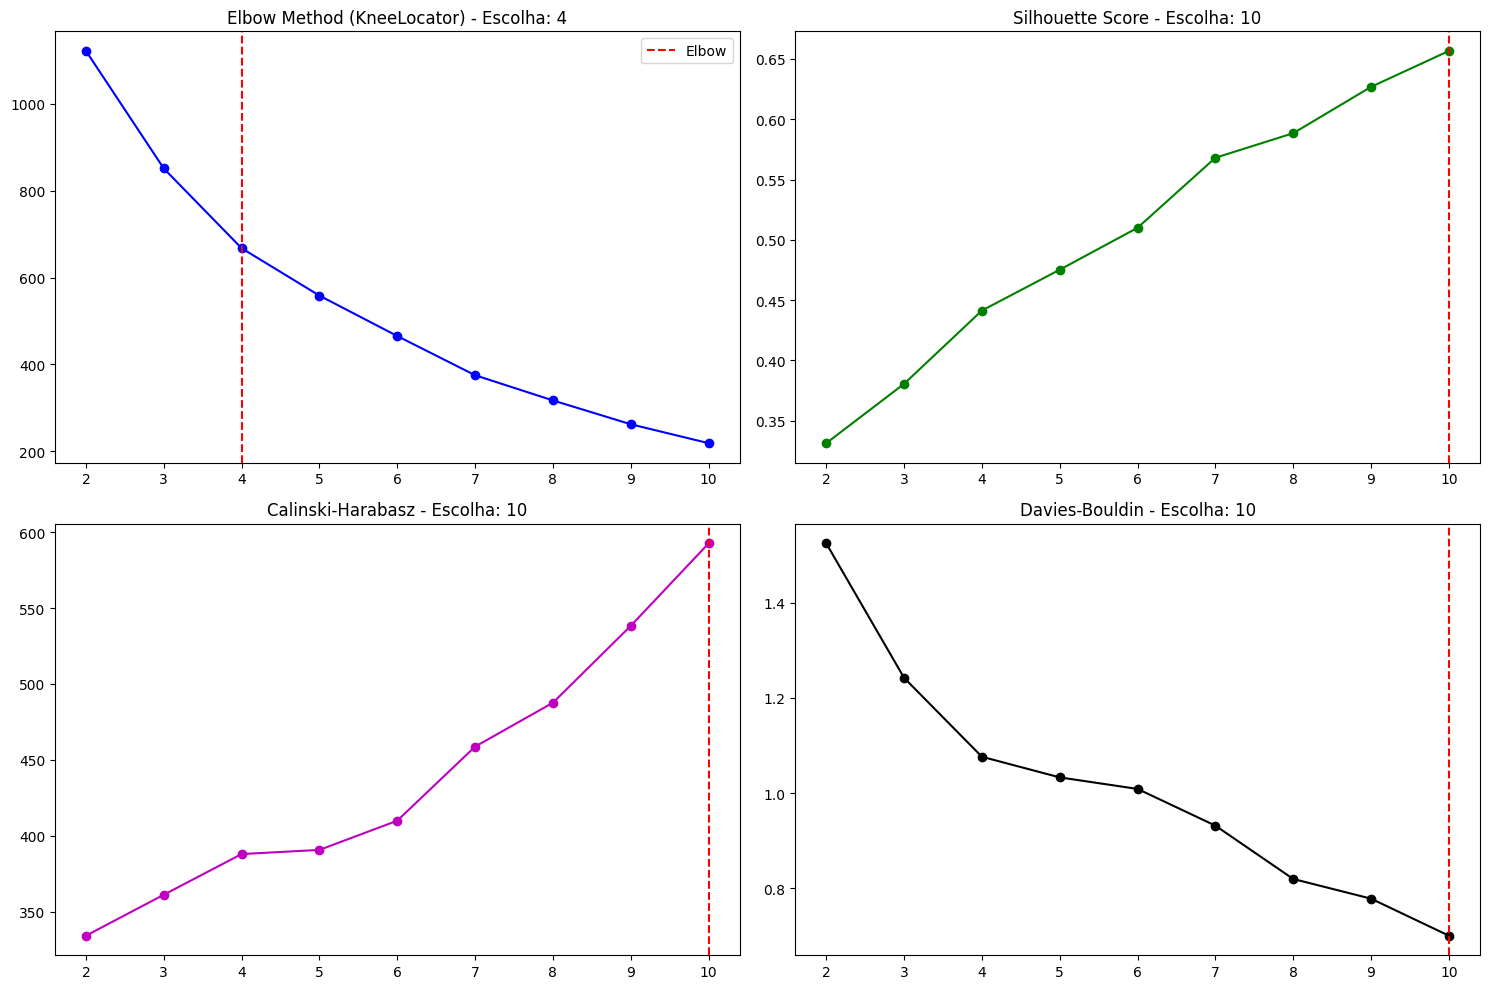

EXECUTANDO K-MEANS FINAL COM K=10
Parâmetros: n_init=50, max_iter=300

--- ATRIBUTOS FINAIS ---

1. Inércia Final: 218.8119
2. Número de iterações: 4

3. Centroides dos Clusters (Cluster Centers):


,Age,SibSp,Parch,Fare,Cabin,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3
Cluster,,,,,,,,,,,,,
0,0.341146,0.052083,0.030093,0.020616,0.013889,4.583333e-01,5.416667e-01,0.000000e+00,1.000000e+00,9.992007e-16,1.942890e-16,5.551115e-17,1.000000e+00
1,0.491250,0.043750,0.041667,0.103687,0.800000,-7.771561e-16,1.000000e+00,-2.775558e-17,1.250000e-02,9.875000e-01,1.000000e+00,0.000000e+00,7.771561e-16
2,0.335472,0.066038,0.042138,0.025029,0.018868,-1.332268e-15,1.000000e+00,1.193490e-15,-2.775558e-16,1.000000e+00,1.942890e-16,-1.443290e-15,1.000000e+00
3,0.380374,0.043224,0.037383,0.038278,0.046729,-3.885781e-16,1.000000e+00,8.411215e-02,9.345794e-03,9.065421e-01,1.942890e-16,1.000000e+00,1.443290e-15
4,0.298438,0.154830,0.166667,0.035445,0.056818,1.000000e+00,-1.332268e-15,5.551115e-17,-1.526557e-16,1.000000e+00,1.665335e-16,0.000000e+00,1.000000e+00
5,0.479070,0.029070,0.054264,0.178007,0.744186,0.000000e+00,1.000000e+00,1.000000e+00,4.163336e-17,-3.330669e-16,9.767442e-01,2.325581e-02,-1.110223e-16
6,0.359667,0.061667,0.102222,0.042760,0.120000,1.000000e+00,-1.221245e-15,8.000000e-02,2.666667e-02,8.933333e-01,1.665335e-16,1.000000e+00,5.551115e-16
7,0.412745,0.073529,0.098039,0.190794,0.901961,1.000000e+00,-8.881784e-16,0.000000e+00,1.960784e-02,9.803922e-01,1.000000e+00,2.775558e-17,-1.110223e-16
8,0.435511,0.062500,0.049242,0.220437,0.818182,1.000000e+00,-7.771561e-16,1.000000e+00,4.163336e-17,-3.330669e-16,9.772727e-01,2.272727e-02,-1.110223e-16


In [ ]:
!pip install -q kneed

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from collections import Counter
from kneed import KneeLocator # <--- NOVA IMPORTAÇÃO

# ==============================================================================
# 1. CÁLCULO DAS MÉTRICAS (K=2 a K=10)
# ==============================================================================
print("Calculando métricas para diferentes valores de K (aguarde)...")

inertias = []
silhouettes = []
calinski = []
davies = []

K_range = range(2, 11) # Testando de 2 a 10 clusters

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=100)
    kmeans.fit(df)
    labels = kmeans.labels_

    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(df, labels))
    calinski.append(calinski_harabasz_score(df, labels))
    davies.append(davies_bouldin_score(df, labels))

# ==============================================================================
# 2. LÓGICA DE SELEÇÃO AUTOMÁTICA (VOTAÇÃO)
# ==============================================================================

# A. Melhor K para Silhouette (Maior é melhor)
best_k_sil = K_range[np.argmax(silhouettes)]

# B. Melhor K para Calinski-Harabasz (Maior é melhor)
best_k_cal = K_range[np.argmax(calinski)]

# C. Melhor K para Davies-Bouldin (Menor é melhor)
best_k_dav = K_range[np.argmin(davies)]

# D. Melhor K para Elbow (USANDO KNEED) <--- ALTERADO AQUI
# Usamos list(K_range) para garantir que x e y tenham o mesmo tamanho
k_elbow_locator = KneeLocator(
    x=list(K_range),
    y=inertias,
    curve="convex",
    direction="decreasing"
)
best_k_elbow = k_elbow_locator.elbow

# Caso o kneed não encontre um ponto (retorne None), usamos um fallback seguro (ex: 3)
if best_k_elbow is None:
    best_k_elbow = 3

# ==============================================================================
# 3. EXIBIÇÃO DOS RESULTADOS DA VOTAÇÃO
# ==============================================================================
print(f"\n--- VOTAÇÃO DOS MÉTODOS ---")
print(f"1. Silhouette Score: K = {best_k_sil} (Quanto maior, melhor)")
print(f"2. Calinski-Harabasz: K = {best_k_cal} (Quanto maior, melhor)")
print(f"3. Davies-Bouldin:    K = {best_k_dav} (Quanto menor, melhor)")
print(f"4. Elbow (KneeLocator): K = {best_k_elbow} (Ponto de inflexão)")

# Contagem de votos
votos = [best_k_sil, best_k_cal, best_k_dav, best_k_elbow]
contagem = Counter(votos)
vencedor_k = contagem.most_common(1)[0][0]

# Critério de desempate: Se houver empate total, preferimos o Silhouette
if contagem.most_common(1)[0][1] == 1:
    print("\nEmpate total! Usando critério de desempate (Silhouette Score).")
    vencedor_k = best_k_sil

print(f"\n>>> VALOR DE K ESCOLHIDO (MAIORIA): {vencedor_k}")

# Plotagem Gráfica
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
axs = axs.flatten()

# Elbow (Visualização ajustada para mostrar o ponto do KneeLocator)
axs[0].plot(K_range, inertias, 'bo-')
axs[0].set_title(f'Elbow Method (KneeLocator) - Escolha: {best_k_elbow}')
if best_k_elbow:
    axs[0].axvline(x=best_k_elbow, color='r', linestyle='--', label='Elbow')
    axs[0].legend()

# Silhouette
axs[1].plot(K_range, silhouettes, 'go-')
axs[1].set_title(f'Silhouette Score - Escolha: {best_k_sil}')
axs[1].axvline(x=best_k_sil, color='r', linestyle='--')

# Calinski
axs[2].plot(K_range, calinski, 'mo-')
axs[2].set_title(f'Calinski-Harabasz - Escolha: {best_k_cal}')
axs[2].axvline(x=best_k_cal, color='r', linestyle='--')

# Davies
axs[3].plot(K_range, davies, 'ko-')
axs[3].set_title(f'Davies-Bouldin - Escolha: {best_k_dav}')
axs[3].axvline(x=best_k_dav, color='r', linestyle='--')

plt.tight_layout()
plt.show()

# ==============================================================================
# 4. RODADA FINAL COM O K VENCEDOR
# ==============================================================================
print("="*60)
print(f"EXECUTANDO K-MEANS FINAL COM K={vencedor_k}")
print(f"Parâmetros: n_init=50, max_iter=300")
print("="*60)

model_final = KMeans(n_clusters=vencedor_k, init='k-means++', n_init=100, max_iter=300, random_state=42)
model_final.fit(df)

# ==============================================================================
# 5. ATRIBUTOS DO MODELO
# ==============================================================================
print("\n--- ATRIBUTOS FINAIS ---")
print(f"\n1. Inércia Final: {model_final.inertia_:.4f}")
print(f"2. Número de iterações: {model_final.n_iter_}")

print("\n3. Centroides dos Clusters (Cluster Centers):")
centroides_df = pd.DataFrame(model_final.cluster_centers_, columns=df.columns)
centroides_df.index.name = 'Cluster'
display(centroides_df)

df_resultado = df.copy()
df_resultado['Cluster_Final'] = model_final.labels_


In [ ]:
from scipy.spatial.distance import pdist, cdist, squareform

print("\n" + "="*60)
print("ANÁLISE AVANÇADA DE DISTÂNCIAS E DENSIDADE")
print("="*60)

# 1. CONTAGEM DE ELEMENTOS POR CLUSTER
# ==============================================================================
counts = pd.Series(model_final.labels_).value_counts().sort_index()
print("Quantidade de elementos por Cluster:")
print(counts)

# 2. INTRA-CLUSTER (Distância média entre pares dentro do mesmo cluster)
# ==============================================================================
# Definição: Média das distâncias de cada ponto para todos os outros pontos do mesmo grupo.
# Quanto MENOR, mais "compacto" e coeso é o cluster.

print("\n--- INTRA-CLUSTER (Média das distâncias entre pares) ---")
intra_cluster_distances = {}

for cluster_id in range(model_final.n_clusters):
    # Seleciona apenas os pontos que pertencem a este cluster
    cluster_points = df[model_final.labels_ == cluster_id]

    # Se o cluster tiver 0 ou 1 elemento, a distância é 0
    if len(cluster_points) <= 1:
        avg_dist = 0.0
    else:
        # pdist calcula a distância entre todos os pares de linhas
        pairwise_dists = pdist(cluster_points, metric='euclidean')
        avg_dist = np.mean(pairwise_dists)

    intra_cluster_distances[cluster_id] = avg_dist
    print(f"Cluster {cluster_id}: {avg_dist:.4f}")

# 3. INTER-CLUSTER (Distância entre os Centroides)
# ==============================================================================
# Definição: Quão distantes os grupos estão uns dos outros.
# Quanto MAIOR, mais distintos e bem separados são os perfis.

print("\n--- INTER-CLUSTER (Matriz de Distância entre Centroides) ---")

centroids = model_final.cluster_centers_

# Calcula a distância de todos para todos (matriz)
inter_dists_matrix = cdist(centroids, centroids, metric='euclidean')

# Transforma em DataFrame para ficar bonito na tela
inter_df = pd.DataFrame(
    inter_dists_matrix,
    index=[f'Cluster {i}' for i in range(model_final.n_clusters)],
    columns=[f'Cluster {i}' for i in range(model_final.n_clusters)]
)

display(inter_df.style.background_gradient(cmap='Reds', axis=None))

print("\nResumo da Análise:")
print("- INTRA-CLUSTER BAIXO: O grupo é muito homogêneo (todos parecidos).")
print("- INTER-CLUSTER ALTO: Os grupos são muito diferentes entre si.")


ANÁLISE AVANÇADA DE DISTÂNCIAS E DENSIDADE
Quantidade de elementos por Cluster:
0     72
1     80
2    265
3    107
4     88
5     43
6     75
7     51
8     44
9     66
Name: count, dtype: int64

--- INTRA-CLUSTER (Média das distâncias entre pares) ---
Cluster 0: 0.8388
Cluster 1: 0.5704
Cluster 2: 0.2806
Cluster 3: 0.5177
Cluster 4: 0.5011
Cluster 5: 0.6970
Cluster 6: 0.6628
Cluster 7: 0.5186
Cluster 8: 0.5993
Cluster 9: 0.7746

--- INTER-CLUSTER (Matriz de Distância entre Centroides) ---


,Cluster 0,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Cluster 5,Cluster 6,Cluster 7,Cluster 8,Cluster 9
Cluster 0,0.000000,2.240102,1.555813,2.057544,1.618611,2.225523,2.087107,2.310190,2.288794,1.423951
Cluster 1,2.240102,0.000000,1.625248,1.611722,2.149983,1.409097,2.122000,1.424188,1.998455,2.209261
Cluster 2,1.555813,1.625248,0.000000,1.421059,1.423486,2.127485,2.008294,2.194824,2.577351,1.498559
Cluster 3,2.057544,1.611722,1.421059,0.000000,2.012931,2.021141,1.418046,2.184711,2.490533,1.978197
Cluster 4,1.618611,2.149983,1.423486,2.012931,0.000000,2.551166,1.427976,1.662394,2.147226,1.695292
Cluster 5,2.225523,1.409097,2.127485,2.021141,2.551166,0.000000,2.445145,1.998996,1.417856,1.669889
Cluster 6,2.087107,2.122000,2.008294,1.418046,1.427976,2.445145,0.000000,1.627999,2.020610,2.124120
Cluster 7,2.310190,1.424188,2.194824,2.184711,1.662394,1.998996,1.627999,0.000000,1.404815,2.375333
Cluster 8,2.288794,1.998455,2.577351,2.490533,2.147226,1.417856,2.020610,1.404815,0.000000,1.873502
Cluster 9,1.423951,2.209261,1.498559,1.978197,1.695292,1.669889,2.124120,2.375333,1.873502,0.000000



Resumo da Análise:
- INTRA-CLUSTER BAIXO: O grupo é muito homogêneo (todos parecidos).
- INTER-CLUSTER ALTO: Os grupos são muito diferentes entre si.


Calculando métricas para diferentes valores de K (aguarde)...

--- VOTAÇÃO DOS MÉTODOS ---
1. Silhouette Score: K = 19 (Quanto maior, melhor)
2. Calinski-Harabasz: K = 18 (Quanto maior, melhor)
3. Davies-Bouldin:    K = 19 (Quanto menor, melhor)
4. Elbow (KneeLocator): K = 8 (Ponto de inflexão)

>>> VALOR DE K ESCOLHIDO (MAIORIA): 19


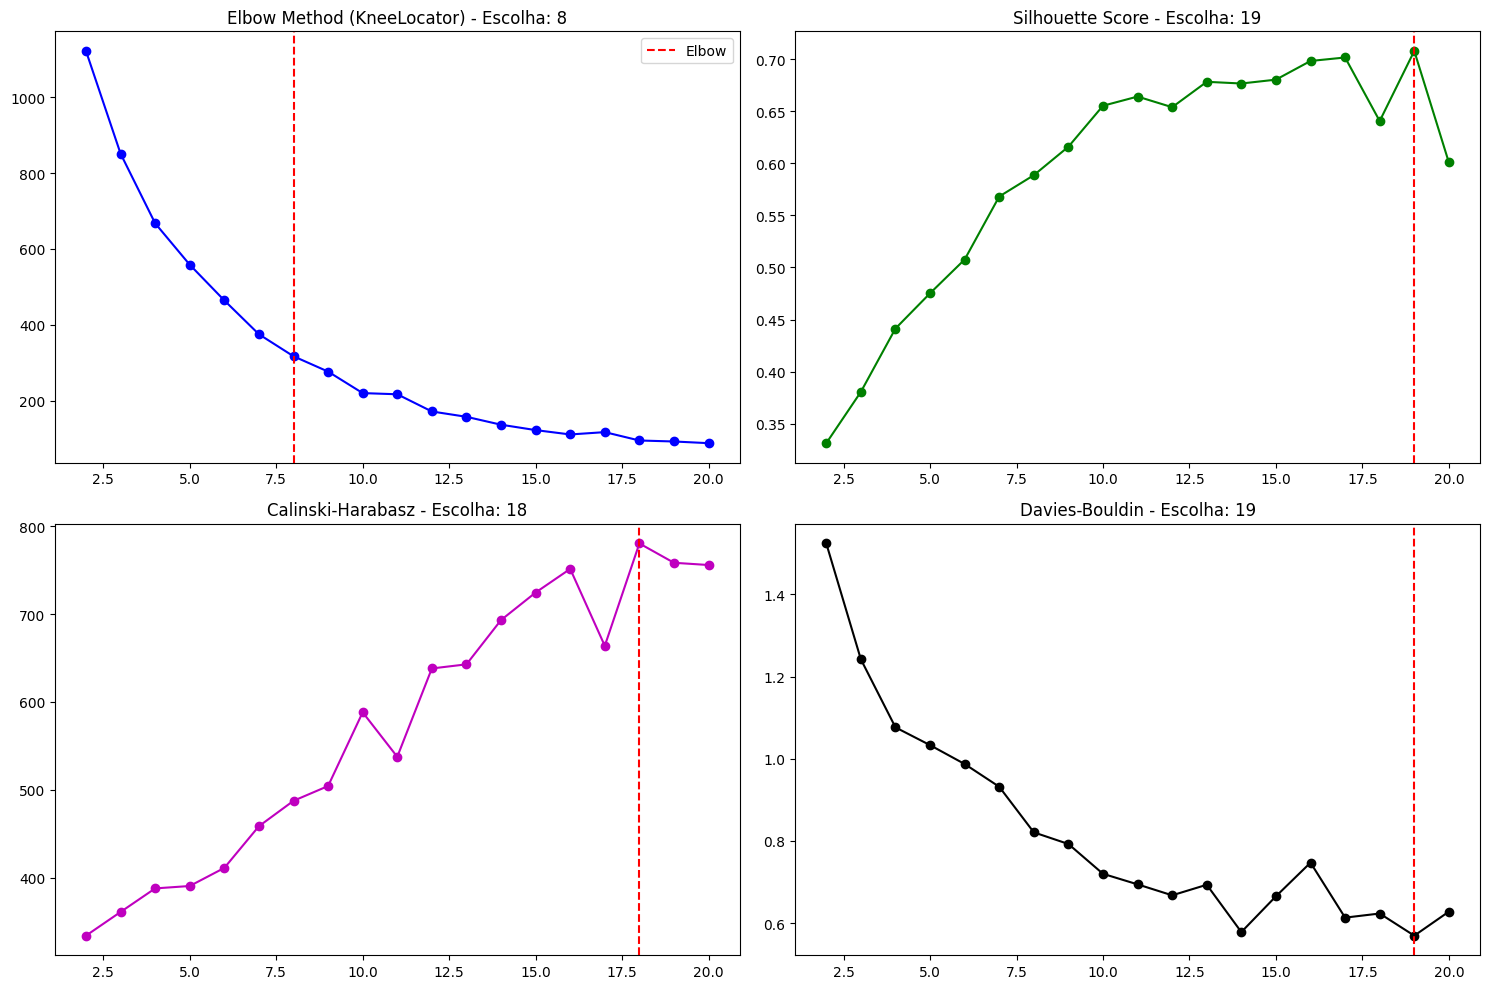

EXECUTANDO K-MEANS FINAL COM K=19
Parâmetros: n_init=100, max_iter=300

--- ATRIBUTOS FINAIS ---

1. Inércia Final: 92.6638
2. Número de iterações: 5

3. Centroides dos Clusters (Cluster Centers):


,Age,SibSp,Parch,Fare,Cabin,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3
Cluster,,,,,,,,,,,,,
0,0.479762,0.029762,5.555556e-02,0.181687,7.380952e-01,5.551115e-17,1.000000e+00,1.000000e+00,5.551115e-17,-3.330669e-16,1.000000e+00,2.775558e-17,-1.110223e-16
1,0.327616,0.029070,2.325581e-02,0.017487,2.775558e-17,0.000000e+00,1.000000e+00,1.000000e+00,4.163336e-17,-3.330669e-16,1.942890e-16,2.775558e-17,1.000000e+00
2,0.351089,0.020747,1.383126e-02,0.019742,2.074689e-02,-8.881784e-16,1.000000e+00,1.137979e-15,-1.665335e-16,1.000000e+00,1.942890e-16,-1.221245e-15,1.000000e+00
3,0.291912,0.073529,8.823529e-02,0.048828,1.176471e-01,4.117647e-01,5.882353e-01,1.000000e+00,2.775558e-17,-2.220446e-16,1.110223e-16,1.000000e+00,-1.110223e-16
4,0.330303,0.026515,4.040404e-02,0.018880,-8.326673e-17,1.000000e+00,-5.551115e-16,0.000000e+00,1.000000e+00,-3.330669e-16,1.665335e-16,2.775558e-17,1.000000e+00
5,0.440278,0.072917,6.018519e-02,0.208171,1.000000e+00,1.000000e+00,-5.551115e-16,9.722222e-01,2.777778e-02,-3.330669e-16,1.000000e+00,5.551115e-17,-1.110223e-16
6,0.390000,0.075000,3.333333e-02,0.225781,-2.775558e-17,1.000000e+00,0.000000e+00,-2.775558e-17,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,-1.110223e-16
7,0.371082,0.059701,1.044776e-01,0.042473,1.194030e-01,1.000000e+00,-1.110223e-15,0.000000e+00,-8.326673e-17,1.000000e+00,1.665335e-16,1.000000e+00,2.220446e-16
8,0.486905,0.045635,5.291005e-02,0.112072,1.000000e+00,-4.440892e-16,1.000000e+00,0.000000e+00,-5.551115e-17,1.000000e+00,1.000000e+00,2.775558e-17,1.110223e-16


In [ ]:
!pip install -q kneed

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from collections import Counter
from kneed import KneeLocator # <--- NOVA IMPORTAÇÃO

# ==============================================================================
# 1. CÁLCULO DAS MÉTRICAS (K=2 a K=10)
# ==============================================================================
print("Calculando métricas para diferentes valores de K (aguarde)...")

inertias = []
silhouettes = []
calinski = []
davies = []

K_range = range(2, 21) # Testando de 2 a 10 clusters

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=100, init="random")
    kmeans.fit(df)
    labels = kmeans.labels_

    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(df, labels))
    calinski.append(calinski_harabasz_score(df, labels))
    davies.append(davies_bouldin_score(df, labels))

# ==============================================================================
# 2. LÓGICA DE SELEÇÃO AUTOMÁTICA (VOTAÇÃO)
# ==============================================================================

# A. Melhor K para Silhouette (Maior é melhor)
best_k_sil = K_range[np.argmax(silhouettes)]

# B. Melhor K para Calinski-Harabasz (Maior é melhor)
best_k_cal = K_range[np.argmax(calinski)]

# C. Melhor K para Davies-Bouldin (Menor é melhor)
best_k_dav = K_range[np.argmin(davies)]

# D. Melhor K para Elbow (USANDO KNEED) <--- ALTERADO AQUI
# Usamos list(K_range) para garantir que x e y tenham o mesmo tamanho
k_elbow_locator = KneeLocator(
    x=list(K_range),
    y=inertias,
    curve="convex",
    direction="decreasing"
)
best_k_elbow = k_elbow_locator.elbow

# Caso o kneed não encontre um ponto (retorne None), usamos um fallback seguro (ex: 3)
if best_k_elbow is None:
    best_k_elbow = 3

# ==============================================================================
# 3. EXIBIÇÃO DOS RESULTADOS DA VOTAÇÃO
# ==============================================================================
print(f"\n--- VOTAÇÃO DOS MÉTODOS ---")
print(f"1. Silhouette Score: K = {best_k_sil} (Quanto maior, melhor)")
print(f"2. Calinski-Harabasz: K = {best_k_cal} (Quanto maior, melhor)")
print(f"3. Davies-Bouldin:    K = {best_k_dav} (Quanto menor, melhor)")
print(f"4. Elbow (KneeLocator): K = {best_k_elbow} (Ponto de inflexão)")

# Contagem de votos
votos = [best_k_sil, best_k_cal, best_k_dav, best_k_elbow]
contagem = Counter(votos)
vencedor_k = contagem.most_common(1)[0][0]

# Critério de desempate: Se houver empate total, preferimos o Silhouette
if contagem.most_common(1)[0][1] == 1:
    print("\nEmpate total! Usando critério de desempate (Silhouette Score).")
    vencedor_k = best_k_sil

print(f"\n>>> VALOR DE K ESCOLHIDO (MAIORIA): {vencedor_k}")

# Plotagem Gráfica
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
axs = axs.flatten()

# Elbow (Visualização ajustada para mostrar o ponto do KneeLocator)
axs[0].plot(K_range, inertias, 'bo-')
axs[0].set_title(f'Elbow Method (KneeLocator) - Escolha: {best_k_elbow}')
if best_k_elbow:
    axs[0].axvline(x=best_k_elbow, color='r', linestyle='--', label='Elbow')
    axs[0].legend()

# Silhouette
axs[1].plot(K_range, silhouettes, 'go-')
axs[1].set_title(f'Silhouette Score - Escolha: {best_k_sil}')
axs[1].axvline(x=best_k_sil, color='r', linestyle='--')

# Calinski
axs[2].plot(K_range, calinski, 'mo-')
axs[2].set_title(f'Calinski-Harabasz - Escolha: {best_k_cal}')
axs[2].axvline(x=best_k_cal, color='r', linestyle='--')

# Davies
axs[3].plot(K_range, davies, 'ko-')
axs[3].set_title(f'Davies-Bouldin - Escolha: {best_k_dav}')
axs[3].axvline(x=best_k_dav, color='r', linestyle='--')

plt.tight_layout()
plt.show()

# ==============================================================================
# 4. RODADA FINAL COM O K VENCEDOR
# ==============================================================================
print("="*60)
print(f"EXECUTANDO K-MEANS FINAL COM K={vencedor_k}")
print(f"Parâmetros: n_init=100, max_iter=300")
print("="*60)

model_final = KMeans(n_clusters=vencedor_k, random_state=42, n_init=100, init="random", max_iter=300)
model_final.fit(df)

# ==============================================================================
# 5. ATRIBUTOS DO MODELO
# ==============================================================================
print("\n--- ATRIBUTOS FINAIS ---")
print(f"\n1. Inércia Final: {model_final.inertia_:.4f}")
print(f"2. Número de iterações: {model_final.n_iter_}")

print("\n3. Centroides dos Clusters (Cluster Centers):")
centroides_df = pd.DataFrame(model_final.cluster_centers_, columns=df.columns)
centroides_df.index.name = 'Cluster'
display(centroides_df)

df_resultado = df.copy()
df_resultado['Cluster_Final'] = model_final.labels_


In [ ]:
from scipy.spatial.distance import pdist, cdist, squareform

print("\n" + "="*60)
print("ANÁLISE AVANÇADA DE DISTÂNCIAS E DENSIDADE")
print("="*60)

# 1. CONTAGEM DE ELEMENTOS POR CLUSTER
# ==============================================================================
counts = pd.Series(model_final.labels_).value_counts().sort_index()
print("Quantidade de elementos por Cluster:")
print(counts)

# 2. INTRA-CLUSTER (Distância média entre pares dentro do mesmo cluster)
# ==============================================================================
# Definição: Média das distâncias de cada ponto para todos os outros pontos do mesmo grupo.
# Quanto MENOR, mais "compacto" e coeso é o cluster.

print("\n--- INTRA-CLUSTER (Média das distâncias entre pares) ---")
intra_cluster_distances = {}

for cluster_id in range(model_final.n_clusters):
    # Seleciona apenas os pontos que pertencem a este cluster
    cluster_points = df[model_final.labels_ == cluster_id]

    # Se o cluster tiver 0 ou 1 elemento, a distância é 0
    if len(cluster_points) <= 1:
        avg_dist = 0.0
    else:
        # pdist calcula a distância entre todos os pares de linhas
        pairwise_dists = pdist(cluster_points, metric='euclidean')
        avg_dist = np.mean(pairwise_dists)

    intra_cluster_distances[cluster_id] = avg_dist
    print(f"Cluster {cluster_id}: {avg_dist:.4f}")

# 3. INTER-CLUSTER (Distância entre os Centroides)
# ==============================================================================
# Definição: Quão distantes os grupos estão uns dos outros.
# Quanto MAIOR, mais distintos e bem separados são os perfis.

print("\n--- INTER-CLUSTER (Matriz de Distância entre Centroides) ---")

centroids = model_final.cluster_centers_

# Calcula a distância de todos para todos (matriz)
inter_dists_matrix = cdist(centroids, centroids, metric='euclidean')

# Transforma em DataFrame para ficar bonito na tela
inter_df = pd.DataFrame(
    inter_dists_matrix,
    index=[f'Cluster {i}' for i in range(model_final.n_clusters)],
    columns=[f'Cluster {i}' for i in range(model_final.n_clusters)]
)

display(inter_df.style.background_gradient(cmap='Reds', axis=None))

print("\nResumo da Análise:")
print("- INTRA-CLUSTER BAIXO: O grupo é muito homogêneo (todos parecidos).")
print("- INTER-CLUSTER ALTO: Os grupos são muito diferentes entre si.")


ANÁLISE AVANÇADA DE DISTÂNCIAS E DENSIDADE
Quantidade de elementos por Cluster:
0      42
1      43
2     241
3      17
4      33
5      36
6       5
7      67
8      63
9       2
10     23
11     24
12     39
13      1
14      8
15     88
16     45
17     98
18     16
Name: count, dtype: int64

--- INTRA-CLUSTER (Média das distâncias entre pares) ---
Cluster 0: 0.6560
Cluster 1: 0.1404
Cluster 2: 0.1946
Cluster 3: 0.9848
Cluster 4: 0.1558
Cluster 5: 0.3806
Cluster 6: 0.2399
Cluster 7: 0.4533
Cluster 8: 0.3050
Cluster 9: 1.0003
Cluster 10: 0.3620
Cluster 11: 0.4241
Cluster 12: 0.2627
Cluster 13: 0.0000
Cluster 14: 0.3780
Cluster 15: 0.5011
Cluster 16: 0.3523
Cluster 17: 0.3447
Cluster 18: 0.2330

--- INTER-CLUSTER (Matriz de Distância entre Centroides) ---


,Cluster 0,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Cluster 5,Cluster 6,Cluster 7,Cluster 8,Cluster 9,Cluster 10,Cluster 11,Cluster 12,Cluster 13,Cluster 14,Cluster 15,Cluster 16,Cluster 17,Cluster 18
Cluster 0,0.000000,1.611192,2.135227,1.667327,2.567853,1.440237,2.134790,2.533231,1.440052,2.469707,2.139637,2.227259,2.133757,1.457791,1.600966,2.558592,2.019226,2.117117,1.600587
Cluster 1,1.611192,0.000000,1.414618,1.536684,2.000077,2.248084,2.459571,2.454446,2.243986,2.500528,1.423658,1.536096,1.415341,2.263595,2.021797,2.010170,2.654326,1.996611,2.008556
Cluster 2,2.135227,1.414618,0.000000,2.088339,2.000401,2.636902,2.011895,2.005089,1.728599,2.496087,2.008391,0.617539,1.415236,2.252909,2.466245,1.430265,2.236631,1.415419,1.423508
Cluster 3,1.667327,1.536684,2.088339,0.000000,2.170887,1.876252,2.179411,1.642805,2.271936,1.690282,1.644551,2.150215,2.087142,2.288952,1.671753,2.169960,2.346345,1.528593,2.099717
Cluster 4,2.567853,2.000077,2.000401,2.170887,0.000000,2.222814,2.012156,2.005414,2.652118,1.501131,1.422641,2.086300,1.415507,2.263728,2.021747,1.427209,2.245472,2.442486,2.456479
Cluster 5,1.440237,2.248084,2.636902,1.876252,2.222814,0.000000,1.717426,2.180784,1.989521,2.046838,1.732086,2.702378,2.623744,1.984566,1.007202,2.214403,1.396167,2.619120,2.230779
Cluster 6,2.134790,2.459571,2.011895,2.179411,2.012156,1.717426,0.000000,1.433008,1.738840,2.073267,2.019466,2.085934,2.458428,2.249408,1.417503,1.439441,1.003802,2.009881,1.429126
Cluster 7,2.533231,2.454446,2.005089,1.642805,2.005414,2.180784,1.433008,0.000000,2.190107,1.469616,2.006925,2.077125,2.452905,2.621519,2.023092,1.422027,1.672880,1.417996,2.011193
Cluster 8,1.440052,2.243986,1.728599,2.271936,2.652118,1.989521,1.738840,2.190107,0.000000,2.505637,2.645182,1.843036,2.231123,1.432691,2.244891,2.226173,1.419316,1.707911,1.002854
Cluster 9,2.469707,2.500528,2.496087,1.690282,1.501131,2.046838,2.073267,1.469616,2.505637,0.000000,2.061686,2.581587,2.056953,2.090661,2.080608,2.062137,2.072768,2.040696,2.504514



Resumo da Análise:
- INTRA-CLUSTER BAIXO: O grupo é muito homogêneo (todos parecidos).
- INTER-CLUSTER ALTO: Os grupos são muito diferentes entre si.


Calculando métricas para diferentes valores de K (aguarde)...

--- VOTAÇÃO DOS MÉTODOS ---
1. Silhouette Score: K = 15 (Quanto maior, melhor)
2. Calinski-Harabasz: K = 20 (Quanto maior, melhor)
3. Davies-Bouldin:    K = 19 (Quanto menor, melhor)
4. Elbow (KneeLocator): K = 7 (Ponto de inflexão)

Empate total! Usando critério de desempate (Silhouette Score).

>>> VALOR DE K ESCOLHIDO (MAIORIA): 15


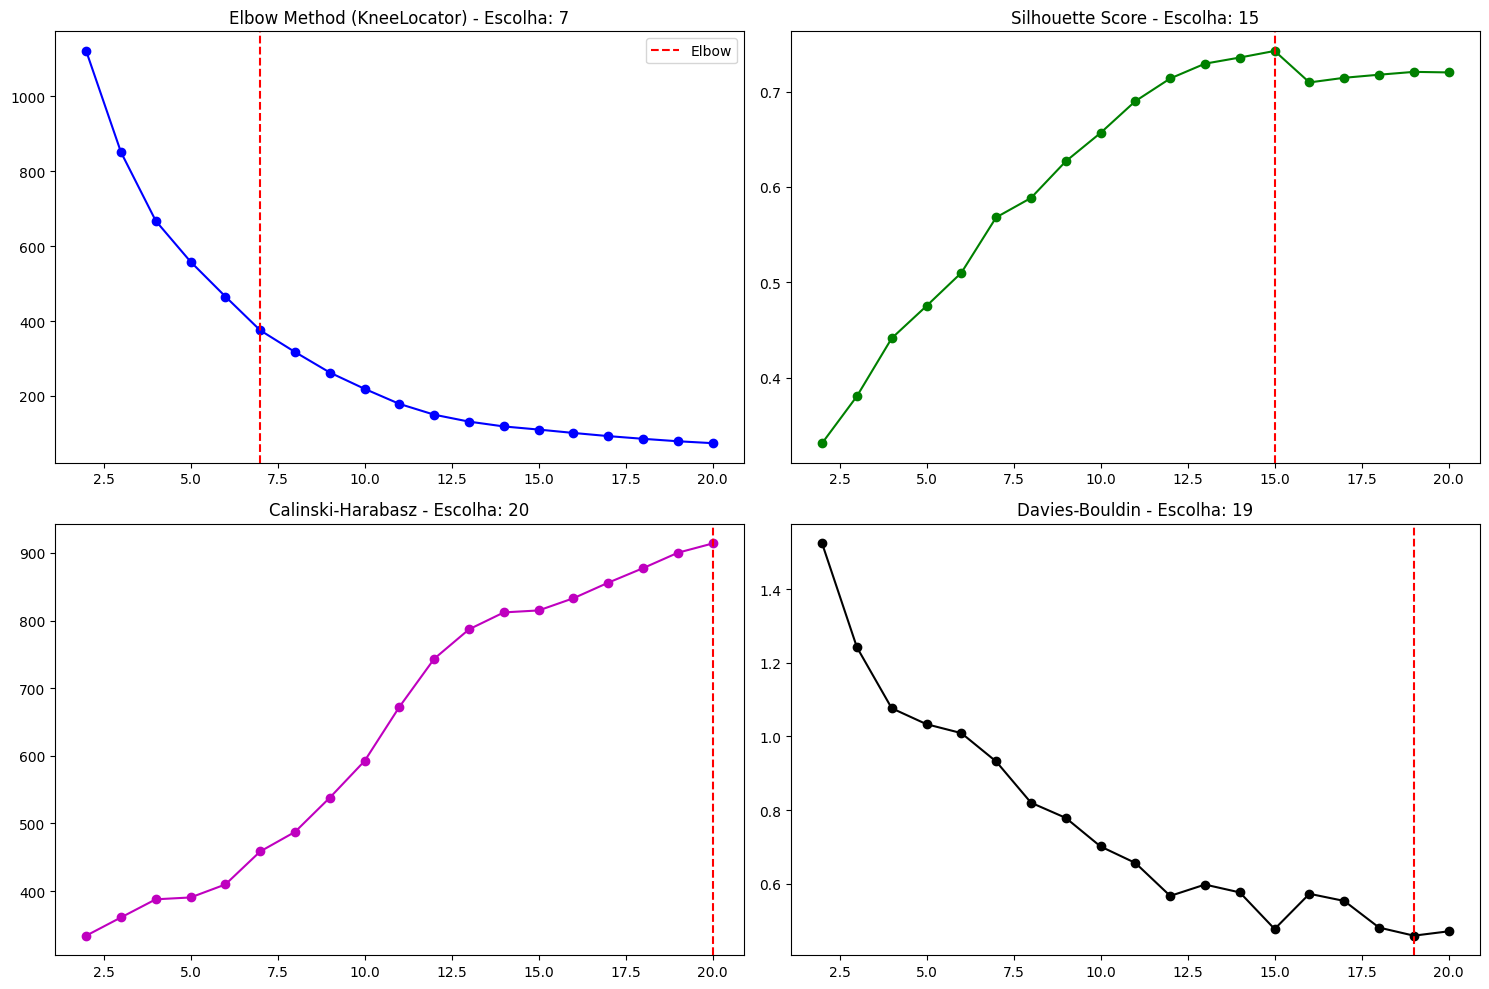

EXECUTANDO K-MEANS FINAL COM K=15
Parâmetros: n_init=50, max_iter=300

--- ATRIBUTOS FINAIS ---

1. Inércia Final: 110.0312
2. Número de iterações: 2

3. Centroides dos Clusters (Cluster Centers):


,Age,SibSp,Parch,Fare,Cabin,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3
Cluster,,,,,,,,,,,,,
0,0.335472,0.066038,4.213836e-02,0.025029,1.886792e-02,-1.332268e-15,1.000000e+00,1.193490e-15,-2.775558e-16,1.000000e+00,1.942890e-16,-1.443290e-15,1.000000e+00
1,0.298438,0.154830,1.666667e-01,0.035445,5.681818e-02,1.000000e+00,-1.332268e-15,5.551115e-17,-1.526557e-16,1.000000e+00,1.665335e-16,0.000000e+00,1.000000e+00
2,0.438352,0.065341,4.924242e-02,0.223855,8.181818e-01,1.000000e+00,-7.771561e-16,9.772727e-01,2.272727e-02,-3.330669e-16,1.000000e+00,0.000000e+00,-1.110223e-16
3,0.412750,0.072500,1.000000e-01,0.191094,9.000000e-01,1.000000e+00,-8.881784e-16,0.000000e+00,1.387779e-17,1.000000e+00,1.000000e+00,2.775558e-17,-1.110223e-16
4,0.382990,0.041237,3.264605e-02,0.037170,5.154639e-02,-6.661338e-16,1.000000e+00,2.220446e-16,-1.387779e-16,1.000000e+00,1.942890e-16,1.000000e+00,1.221245e-15
5,0.487891,0.048828,5.208333e-02,0.113068,1.000000e+00,-4.996004e-16,1.000000e+00,0.000000e+00,1.562500e-02,9.843750e-01,1.000000e+00,2.775558e-17,1.110223e-16
6,0.371082,0.059701,1.044776e-01,0.042473,1.194030e-01,1.000000e+00,-1.110223e-15,0.000000e+00,-8.326673e-17,1.000000e+00,1.665335e-16,1.000000e+00,2.220446e-16
7,0.479762,0.029762,5.555556e-02,0.181687,7.380952e-01,5.551115e-17,1.000000e+00,1.000000e+00,5.551115e-17,-3.330669e-16,1.000000e+00,2.775558e-17,-1.110223e-16
8,0.350321,0.073718,2.136752e-02,0.022085,2.564103e-02,0.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,-3.330669e-16,1.942890e-16,2.775558e-17,1.000000e+00


In [ ]:
!pip install -q kneed

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from collections import Counter
from kneed import KneeLocator # <--- NOVA IMPORTAÇÃO

# ==============================================================================
# 1. CÁLCULO DAS MÉTRICAS (K=2 a K=10)
# ==============================================================================
print("Calculando métricas para diferentes valores de K (aguarde)...")

inertias = []
silhouettes = []
calinski = []
davies = []

K_range = range(2, 21) # Testando de 2 a 10 clusters

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=100)
    kmeans.fit(df)
    labels = kmeans.labels_

    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(df, labels))
    calinski.append(calinski_harabasz_score(df, labels))
    davies.append(davies_bouldin_score(df, labels))

# ==============================================================================
# 2. LÓGICA DE SELEÇÃO AUTOMÁTICA (VOTAÇÃO)
# ==============================================================================

# A. Melhor K para Silhouette (Maior é melhor)
best_k_sil = K_range[np.argmax(silhouettes)]

# B. Melhor K para Calinski-Harabasz (Maior é melhor)
best_k_cal = K_range[np.argmax(calinski)]

# C. Melhor K para Davies-Bouldin (Menor é melhor)
best_k_dav = K_range[np.argmin(davies)]

# D. Melhor K para Elbow (USANDO KNEED) <--- ALTERADO AQUI
# Usamos list(K_range) para garantir que x e y tenham o mesmo tamanho
k_elbow_locator = KneeLocator(
    x=list(K_range),
    y=inertias,
    curve="convex",
    direction="decreasing"
)
best_k_elbow = k_elbow_locator.elbow

# Caso o kneed não encontre um ponto (retorne None), usamos um fallback seguro (ex: 3)
if best_k_elbow is None:
    best_k_elbow = 3

# ==============================================================================
# 3. EXIBIÇÃO DOS RESULTADOS DA VOTAÇÃO
# ==============================================================================
print(f"\n--- VOTAÇÃO DOS MÉTODOS ---")
print(f"1. Silhouette Score: K = {best_k_sil} (Quanto maior, melhor)")
print(f"2. Calinski-Harabasz: K = {best_k_cal} (Quanto maior, melhor)")
print(f"3. Davies-Bouldin:    K = {best_k_dav} (Quanto menor, melhor)")
print(f"4. Elbow (KneeLocator): K = {best_k_elbow} (Ponto de inflexão)")

# Contagem de votos
votos = [best_k_sil, best_k_cal, best_k_dav, best_k_elbow]
contagem = Counter(votos)
vencedor_k = contagem.most_common(1)[0][0]

# Critério de desempate: Se houver empate total, preferimos o Silhouette
if contagem.most_common(1)[0][1] == 1:
    print("\nEmpate total! Usando critério de desempate (Silhouette Score).")
    vencedor_k = best_k_sil

print(f"\n>>> VALOR DE K ESCOLHIDO (MAIORIA): {vencedor_k}")

# Plotagem Gráfica
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
axs = axs.flatten()

# Elbow (Visualização ajustada para mostrar o ponto do KneeLocator)
axs[0].plot(K_range, inertias, 'bo-')
axs[0].set_title(f'Elbow Method (KneeLocator) - Escolha: {best_k_elbow}')
if best_k_elbow:
    axs[0].axvline(x=best_k_elbow, color='r', linestyle='--', label='Elbow')
    axs[0].legend()

# Silhouette
axs[1].plot(K_range, silhouettes, 'go-')
axs[1].set_title(f'Silhouette Score - Escolha: {best_k_sil}')
axs[1].axvline(x=best_k_sil, color='r', linestyle='--')

# Calinski
axs[2].plot(K_range, calinski, 'mo-')
axs[2].set_title(f'Calinski-Harabasz - Escolha: {best_k_cal}')
axs[2].axvline(x=best_k_cal, color='r', linestyle='--')

# Davies
axs[3].plot(K_range, davies, 'ko-')
axs[3].set_title(f'Davies-Bouldin - Escolha: {best_k_dav}')
axs[3].axvline(x=best_k_dav, color='r', linestyle='--')

plt.tight_layout()
plt.show()

# ==============================================================================
# 4. RODADA FINAL COM O K VENCEDOR
# ==============================================================================
print("="*60)
print(f"EXECUTANDO K-MEANS FINAL COM K={vencedor_k}")
print(f"Parâmetros: n_init=50, max_iter=300")
print("="*60)

model_final = KMeans(n_clusters=vencedor_k, init='k-means++', n_init=100, max_iter=300, random_state=42)
model_final.fit(df)

# ==============================================================================
# 5. ATRIBUTOS DO MODELO
# ==============================================================================
print("\n--- ATRIBUTOS FINAIS ---")
print(f"\n1. Inércia Final: {model_final.inertia_:.4f}")
print(f"2. Número de iterações: {model_final.n_iter_}")

print("\n3. Centroides dos Clusters (Cluster Centers):")
centroides_df = pd.DataFrame(model_final.cluster_centers_, columns=df.columns)
centroides_df.index.name = 'Cluster'
display(centroides_df)

df_resultado = df.copy()
df_resultado['Cluster_Final'] = model_final.labels_


In [ ]:
from scipy.spatial.distance import pdist, cdist, squareform

print("\n" + "="*60)
print("ANÁLISE AVANÇADA DE DISTÂNCIAS E DENSIDADE")
print("="*60)

# 1. CONTAGEM DE ELEMENTOS POR CLUSTER
# ==============================================================================
counts = pd.Series(model_final.labels_).value_counts().sort_index()
print("Quantidade de elementos por Cluster:")
print(counts)

# 2. INTRA-CLUSTER (Distância média entre pares dentro do mesmo cluster)
# ==============================================================================
# Definição: Média das distâncias de cada ponto para todos os outros pontos do mesmo grupo.
# Quanto MENOR, mais "compacto" e coeso é o cluster.

print("\n--- INTRA-CLUSTER (Média das distâncias entre pares) ---")
intra_cluster_distances = {}

for cluster_id in range(model_final.n_clusters):
    # Seleciona apenas os pontos que pertencem a este cluster
    cluster_points = df[model_final.labels_ == cluster_id]

    # Se o cluster tiver 0 ou 1 elemento, a distância é 0
    if len(cluster_points) <= 1:
        avg_dist = 0.0
    else:
        # pdist calcula a distância entre todos os pares de linhas
        pairwise_dists = pdist(cluster_points, metric='euclidean')
        avg_dist = np.mean(pairwise_dists)

    intra_cluster_distances[cluster_id] = avg_dist
    print(f"Cluster {cluster_id}: {avg_dist:.4f}")

# 3. INTER-CLUSTER (Distância entre os Centroides)
# ==============================================================================
# Definição: Quão distantes os grupos estão uns dos outros.
# Quanto MAIOR, mais distintos e bem separados são os perfis.

print("\n--- INTER-CLUSTER (Matriz de Distância entre Centroides) ---")

centroids = model_final.cluster_centers_

# Calcula a distância de todos para todos (matriz)
inter_dists_matrix = cdist(centroids, centroids, metric='euclidean')

# Transforma em DataFrame para ficar bonito na tela
inter_df = pd.DataFrame(
    inter_dists_matrix,
    index=[f'Cluster {i}' for i in range(model_final.n_clusters)],
    columns=[f'Cluster {i}' for i in range(model_final.n_clusters)]
)

display(inter_df.style.background_gradient(cmap='Reds', axis=None))

print("\nResumo da Análise:")
print("- INTRA-CLUSTER BAIXO: O grupo é muito homogêneo (todos parecidos).")
print("- INTER-CLUSTER ALTO: Os grupos são muito diferentes entre si.")


ANÁLISE AVANÇADA DE DISTÂNCIAS E DENSIDADE
Quantidade de elementos por Cluster:
0     265
1      88
2      44
3      50
4      97
5      64
6      67
7      42
8      39
9      43
10     23
11     35
12     16
13     11
14      7
Name: count, dtype: int64

--- INTRA-CLUSTER (Média das distâncias entre pares) ---
Cluster 0: 0.2806
Cluster 1: 0.5011
Cluster 2: 0.5984
Cluster 3: 0.4796
Cluster 4: 0.3209
Cluster 5: 0.3409
Cluster 6: 0.4533
Cluster 7: 0.6560
Cluster 8: 0.2627
Cluster 9: 0.1404
Cluster 10: 0.3620
Cluster 11: 0.3157
Cluster 12: 0.2330
Cluster 13: 0.6005
Cluster 14: 0.4937

--- INTER-CLUSTER (Matriz de Distância entre Centroides) ---


,Cluster 0,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Cluster 5,Cluster 6,Cluster 7,Cluster 8,Cluster 9,Cluster 10,Cluster 11,Cluster 12,Cluster 13,Cluster 14
Cluster 0,0.000000,1.423486,2.577721,2.193931,1.415690,1.730458,2.003898,2.136386,1.414484,1.414990,2.005337,2.002092,1.426279,1.960199,2.455308
Cluster 1,1.423486,0.000000,2.147586,1.661166,2.009489,2.226289,1.422027,2.558592,2.007868,2.010170,1.418859,1.429026,2.022808,2.420356,2.005111
Cluster 2,2.577721,2.147586,0.000000,1.402366,2.565557,1.993031,2.117635,1.418536,2.566623,2.174234,1.640660,2.116788,2.158344,2.139151,1.590643
Cluster 3,2.193931,1.661166,1.402366,0.000000,2.179442,1.423053,1.622757,2.008630,2.608285,2.618237,2.189950,2.166515,1.687148,2.552143,2.150344
Cluster 4,1.415690,2.009489,2.565557,2.179442,0.000000,1.707997,1.417842,2.121852,2.000787,2.001586,2.456859,2.404515,1.421158,1.356034,2.008817
Cluster 5,1.730458,2.226289,1.993031,1.423053,1.707997,0.000000,2.190304,1.429329,2.217235,2.237249,2.639488,2.609166,1.003159,2.155927,2.602575
Cluster 6,2.003898,1.422027,2.117635,1.622757,1.417842,2.190304,0.000000,2.533231,2.452905,2.454446,2.006925,1.947789,2.011193,1.958680,1.420886
Cluster 7,2.136386,2.558592,1.418536,2.008630,2.121852,1.429329,2.533231,0.000000,2.133757,1.611192,2.139637,2.538545,1.600587,1.571059,2.105939
Cluster 8,1.414484,2.007868,2.566623,2.608285,2.000787,2.217235,2.452905,2.133757,0.000000,1.415341,2.007218,1.417579,2.007340,1.913421,2.456108
Cluster 9,1.414990,2.010170,2.174234,2.618237,2.001586,2.237249,2.454446,1.611192,1.415341,0.000000,1.423658,2.001901,2.008556,1.424946,2.009473



Resumo da Análise:
- INTRA-CLUSTER BAIXO: O grupo é muito homogêneo (todos parecidos).
- INTER-CLUSTER ALTO: Os grupos são muito diferentes entre si.


--- INICIANDO TRATAMENTO: APENAS VARIÁVEIS NUMÉRICAS ---
Features selecionadas: ['Age', 'Fare', 'SibSp', 'Parch']
Valores nulos tratados (Mediana).
Normalização aplicada em todas as colunas.


/tmp/ipython-input-2516302116.py:33: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_num['Age'].fillna(mediana_age, inplace=True)


,Age,Fare,SibSp,Parch
0,0.271174,0.014151,0.125,0.0
1,0.472229,0.139136,0.125,0.0
2,0.321438,0.015469,0.000,0.0
3,0.434531,0.103644,0.125,0.0
4,0.434531,0.015713,0.000,0.0



Calculando métricas para K=2 a K=10...

--- VOTAÇÃO DOS MÉTODOS (Abordagem Numérica) ---
1. Silhouette Score:  K = 2
2. Calinski-Harabasz: K = 10
3. Davies-Bouldin:    K = 9
4. Elbow (Knee):      K = 4

>>> K ESCOLHIDO: 10


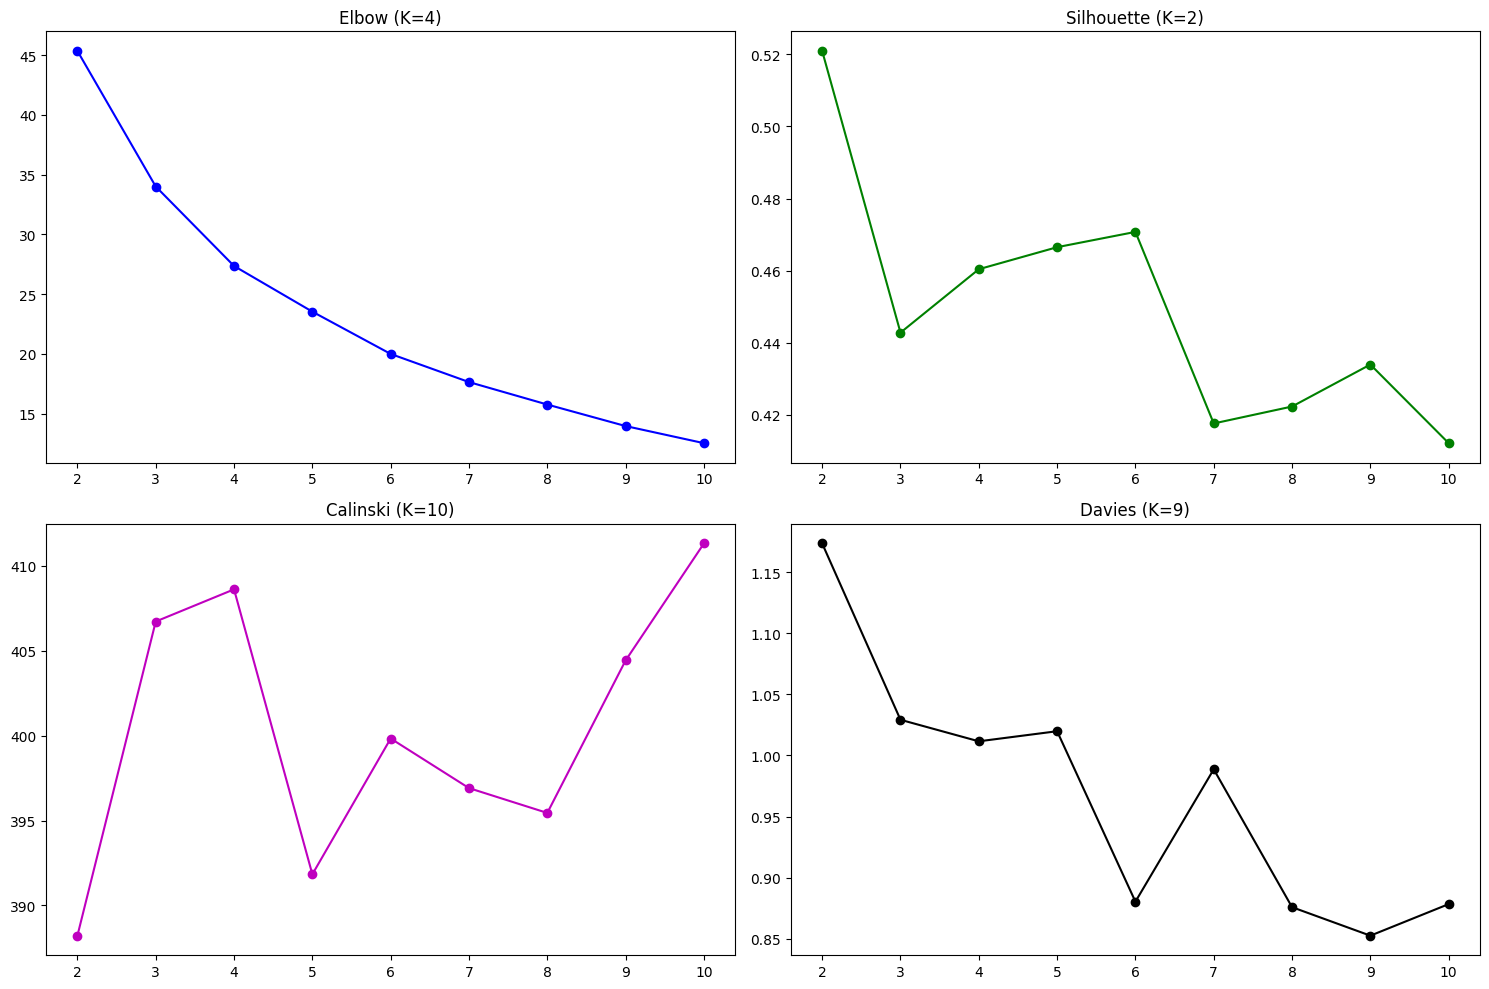

EXECUTANDO K-MEANS FINAL COM K=10

Inércia Final: 12.4684
Iterações para convergir: 24

--- CENTROIDES FINAIS ---


,Age,Fare,SibSp,Parch
Cluster,,,,
0,0.356802,0.074919,0.158333,0.009524
1,0.085197,0.063938,0.491667,0.266667
2,0.382113,0.079162,0.078571,0.242857
3,0.370445,0.535597,0.093750,0.150000
4,0.346569,0.135753,1.000000,0.333333
5,0.371354,0.031938,-0.000000,-0.000000
6,0.084551,0.067648,0.090909,0.233333
7,0.647289,0.073385,0.034351,0.024173
8,0.243675,0.030486,0.012175,0.003247


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.preprocessing import MinMaxScaler
from collections import Counter
from kneed import KneeLocator
from scipy.spatial.distance import pdist, cdist

# ==============================================================================
# 0. CARREGAMENTO E SELEÇÃO DE FEATURES (Abordagem 100% Numérica)
# ==============================================================================
print("--- INICIANDO TRATAMENTO: APENAS VARIÁVEIS NUMÉRICAS ---")

# Recarregando para garantir "limpeza"
df_num = pd.read_csv('train.csv')

# Lista exata das colunas que queremos manter
features_desejadas = ['Age', 'Fare', 'SibSp', 'Parch']

# Seleciona apenas elas (descartando PassengerId, Name, Ticket, Cabin, Embarked, Sex, Pclass e Survived)
df_num = df_num[features_desejadas]

print(f"Features selecionadas: {list(df_num.columns)}")

# ==============================================================================
# 1. TRATAMENTO DE VALORES FALTANTES
# ==============================================================================

# Preenche Age com Mediana
mediana_age = df_num['Age'].median()
df_num['Age'].fillna(mediana_age, inplace=True)

# Prevenção: Caso haja algum nulo em Fare, preenche com mediana
# df_num['Fare'].fillna(df_num['Fare'].median(), inplace=True)

print("Valores nulos tratados (Mediana).")

# ==============================================================================
# 2. NORMALIZAÇÃO (MinMaxScaler)
# ==============================================================================
# Como todas são numéricas, normalizamos o dataframe inteiro
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_num), columns=df_num.columns)

print("Normalização aplicada em todas as colunas.")
display(df_scaled.head())

# ==============================================================================
# 3. LOOP DE VOTAÇÃO DO MELHOR K
# ==============================================================================
print("\nCalculando métricas para K=2 a K=10...")

inertias = []
silhouettes = []
calinski = []
davies = []

K_range = range(2, 11)

for k in K_range:
    # n_init=10 para ser rápido na busca
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df_scaled)
    labels = kmeans.labels_

    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(df_scaled, labels))
    calinski.append(calinski_harabasz_score(df_scaled, labels))
    davies.append(davies_bouldin_score(df_scaled, labels))

# --- Lógica de Decisão ---
best_k_sil = K_range[np.argmax(silhouettes)]
best_k_cal = K_range[np.argmax(calinski)]
best_k_dav = K_range[np.argmin(davies)]

# Elbow com KneeLocator
k_elbow_locator = KneeLocator(x=list(K_range), y=inertias, curve="convex", direction="decreasing")
best_k_elbow = k_elbow_locator.elbow if k_elbow_locator.elbow else 3

print(f"\n--- VOTAÇÃO DOS MÉTODOS (Abordagem Numérica) ---")
print(f"1. Silhouette Score:  K = {best_k_sil}")
print(f"2. Calinski-Harabasz: K = {best_k_cal}")
print(f"3. Davies-Bouldin:    K = {best_k_dav}")
print(f"4. Elbow (Knee):      K = {best_k_elbow}")

votos = [best_k_sil, best_k_cal, best_k_dav, best_k_elbow]
contagem = Counter(votos)
vencedor_k = contagem.most_common(1)[0][0]

# Desempate
if contagem.most_common(1)[0][1] == 1:
    # print("Empate! Usando Silhouette como critério.")
    # vencedor_k = best_k_sil
    vencedor_k = 10

print(f"\n>>> K ESCOLHIDO: {vencedor_k}")

# Plotagem Gráfica
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
axs = axs.flatten()
axs[0].plot(K_range, inertias, 'bo-'); axs[0].set_title(f'Elbow (K={best_k_elbow})')
axs[1].plot(K_range, silhouettes, 'go-'); axs[1].set_title(f'Silhouette (K={best_k_sil})')
axs[2].plot(K_range, calinski, 'mo-'); axs[2].set_title(f'Calinski (K={best_k_cal})')
axs[3].plot(K_range, davies, 'ko-'); axs[3].set_title(f'Davies (K={best_k_dav})')
plt.tight_layout()
plt.show()

# ==============================================================================
# 4. RODADA FINAL (MODELO DEFINITIVO)
# ==============================================================================
print("="*60)
print(f"EXECUTANDO K-MEANS FINAL COM K={vencedor_k}")
print("="*60)

model_final = KMeans(n_clusters=vencedor_k, init='k-means++', n_init=50, max_iter=300, random_state=42)
model_final.fit(df_scaled)

print(f"\nInércia Final: {model_final.inertia_:.4f}")
print(f"Iterações para convergir: {model_final.n_iter_}")

print("\n--- CENTROIDES FINAIS ---")
centroides_df = pd.DataFrame(model_final.cluster_centers_, columns=df_scaled.columns)
centroides_df.index.name = 'Cluster'
display(centroides_df.style.background_gradient(cmap='Greens'))



In [ ]:
# ==============================================================================
# 5. ANÁLISE AVANÇADA (INTRA e INTER CLUSTER)
# ==============================================================================

# Contagem
counts = pd.Series(model_final.labels_).value_counts().sort_index()
print("\nQuantidade de elementos por Cluster:")
print(counts)

# Intra-Cluster
print("\n--- INTRA-CLUSTER (Coesão: Média das distâncias internas) ---")
for cluster_id in range(model_final.n_clusters):
    cluster_points = df_scaled[model_final.labels_ == cluster_id]
    if len(cluster_points) <= 1:
        avg_dist = 0.0
    else:
        pairwise_dists = pdist(cluster_points, metric='euclidean')
        avg_dist = np.mean(pairwise_dists)
    print(f"Cluster {cluster_id}: {avg_dist:.4f}")

# Inter-Cluster
print("\n--- INTER-CLUSTER (Separação: Distância entre Centroides) ---")
centroids = model_final.cluster_centers_
inter_dists_matrix = cdist(centroids, centroids, metric='euclidean')
inter_df = pd.DataFrame(inter_dists_matrix,
                        index=[f'C{i}' for i in range(model_final.n_clusters)],
                        columns=[f'C{i}' for i in range(model_final.n_clusters)])

display(inter_df.style.background_gradient(cmap='Reds', axis=None))


Quantidade de elementos por Cluster:
0    105
1     30
2     70
3     20
4      7
5    307
6     55
7    131
8    154
9     12
Name: count, dtype: int64

--- INTRA-CLUSTER (Coesão: Média das distâncias internas) ---
Cluster 0: 0.1478
Cluster 1: 0.1722
Cluster 2: 0.2084
Cluster 3: 0.4058
Cluster 4: 0.0000
Cluster 5: 0.0659
Cluster 6: 0.2063
Cluster 7: 0.1880
Cluster 8: 0.0799
Cluster 9: 0.2882

--- INTER-CLUSTER (Separação: Distância entre Centroides) ---


,C0,C1,C2,C3,C4,C5,C6,C7,C8,C9
C0,0.000000,0.501122,0.247922,0.486122,0.903914,0.164983,0.358901,0.316183,0.190193,0.752045
C1,0.501122,0.000000,0.509515,0.689766,0.579931,0.629092,0.402159,0.764184,0.570558,0.764943
C2,0.247922,0.509515,0.000000,0.466177,0.928268,0.259806,0.298193,0.346598,0.288714,0.517953
C3,0.486122,0.689766,0.466177,0.000000,1.007644,0.533818,0.554675,0.556456,0.547173,0.750022
C4,0.903914,0.579931,0.928268,1.007644,0.000000,1.059482,0.953802,1.059424,1.051866,1.010749
C5,0.164983,0.629092,0.259806,0.533818,1.059482,0.000000,0.382413,0.282175,0.128307,0.763509
C6,0.358901,0.402159,0.298193,0.554675,0.953802,0.382413,0.000000,0.603038,0.292985,0.677906
C7,0.316183,0.764184,0.346598,0.556456,1.059424,0.282175,0.603038,0.000000,0.407031,0.723136
C8,0.190193,0.570558,0.288714,0.547173,1.051866,0.128307,0.292985,0.407031,0.000000,0.796960
C9,0.752045,0.764943,0.517953,0.750022,1.010749,0.763509,0.677906,0.723136,0.796960,0.000000


#A partir desta célula começa o K-Prototypes

In [ ]:
!pip install -q kmodes # Inclui k-prototypes e k-modes
!pip install -q kneed

from google.colab import files
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from sklearn.preprocessing import MinMaxScaler
from kmodes.kprototypes import KPrototypes
# from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from kneed import KneeLocator
from collections import Counter

# ==============================================================================
# 1. CARREGAMENTO E PRÉ-PROCESSAMENTO OTIMIZADO PARA K-PROTOTYPES
# ==============================================================================
print("\n--- INICIANDO PRÉ-PROCESSAMENTO PARA K-PROTOTYPES ---")

try:
    # Tentativa de carregar o arquivo, caso não tenha sido executado
    df = pd.read_csv('train.csv')
    df.drop(columns=['Survived'], inplace=True) # Remove a coluna alvo, como feito
except FileNotFoundError:
    print("ERRO: O arquivo 'train.csv' não foi encontrado. Certifique-se de que a célula de download de dados foi executada.")
    # Usar a cópia do df do notebook para continuar
    df = pd.DataFrame(df)

# A. TRATAMENTO DE VALORES FALTANTES (Igual ao seu)
# ------------------------------------------------------------------------------
mediana_age = df['Age'].median()
df['Age'].fillna(mediana_age, inplace=True)

moda_embarked = df['Embarked'].mode()[0]
df['Embarked'].fillna(moda_embarked, inplace=True)

print("1. Nulos em 'Age' (Mediana) e 'Embarked' (Moda) preenchidos.")

# B. FEATURE ENGINEERING: CABIN (AGORA CATEGÓRICA)
# ------------------------------------------------------------------------------
# 0 se nulo, 1 se valor. O importante é o .astype(str) no final.
df['Cabin'] = df['Cabin'].notna().astype(int).astype(str)
print("1. 'Cabin' transformada em binária e mantida como Categórica ('0' ou '1').")


# C. REMOÇÃO DE COLUNAS DESNECESSÁRIAS (Igual ao seu)
# ------------------------------------------------------------------------------
cols_to_drop = ['PassengerId', 'Name', 'Ticket']
cols_present = [c for c in cols_to_drop if c in df.columns]
df.drop(columns=cols_present, inplace=True)
print(f"3. Colunas removidas: {cols_present}")


# D. SEPARAÇÃO E IDENTIFICAÇÃO DE TIPOS
# ------------------------------------------------------------------------------
# Pclass é numérica (int64) no original, mas é CATEGÓRICA para agrupamento
df['Pclass'] = df['Pclass'].astype(str)

numeric_cols = ['Age', 'Fare', 'SibSp', 'Parch']
categorical_cols = ['Sex', 'Embarked', 'Pclass', 'Cabin'] # Deixamos como string/object

# O DataFrame final terá a ORDEM correta para o KPrototypes: Numéricas + Categóricas
df_final = df[numeric_cols + categorical_cols].copy()

print("\n4. Colunas categóricas mantidas como string (sem One-Hot Encoding):")
print(f"   {categorical_cols}")


# E. NORMALIZAÇÃO SELETIVA (APENAS FEATURES CONTÍNUAS)
# ------------------------------------------------------------------------------
# Normaliza apenas Age, Fare, SibSp, Parch
cols_to_normalize = ['Age', 'Fare', 'SibSp', 'Parch']
print(f"\n5. Normalizando apenas: {cols_to_normalize}")

scaler = MinMaxScaler()
df_final[cols_to_normalize] = scaler.fit_transform(df_final[cols_to_normalize])

'''# F. CÁLCULO DINÂMICO DE GAMMA (NOVO PASSO)
# ==============================================================================

# Calcula o desvio padrão de cada feature numérica
std_devs = df_final[numeric_cols].std()

# Calcula gamma como a média desses desvios padrão
gamma = std_devs.mean()

print(f"\nDesvios Padrão (Numéricas):")
print(std_devs)
print(f"\n>>> GAMMA CALCULADO (MÉDIA DOS DESVIOS PADRÃO): {gamma:.4f}")'''

# G. ÍNDICES DAS COLUNAS CATEGÓRICAS
# ------------------------------------------------------------------------------
# O KPrototypes precisa dos *índices* das colunas categóricas no array NumPy
# As colunas categóricas estão após as numéricas.
num_features = len(numeric_cols)
# Os índices categóricos começam no número de colunas numéricas
categorical_indices = [df_final.columns.get_loc(col) for col in categorical_cols]

# print(f"\nColunas numéricas ({len(numeric_cols)}): {list(numeric_cols)}")
# print(f"Colunas categóricas ({len(categorical_cols)}): {list(categorical_cols)}")
# print(f"Índices Categóricos no Array Final (necessário para KPrototypes): {categorical_indices}")

# Converte para array numpy, que é o que o KPrototypes espera
data_array = df_final.values

print("\n--- DATASET FINAL PRONTO PARA K-PROTOTYPES ---")
print(f"Shape final: {data_array.shape}")
display(df_final.head())



--- INICIANDO PRÉ-PROCESSAMENTO PARA K-PROTOTYPES ---
1. Nulos em 'Age' (Mediana) e 'Embarked' (Moda) preenchidos.
1. 'Cabin' transformada em binária e mantida como Categórica ('0' ou '1').
3. Colunas removidas: ['PassengerId', 'Name', 'Ticket']

4. Colunas categóricas mantidas como string (sem One-Hot Encoding):
   ['Sex', 'Embarked', 'Pclass', 'Cabin']

5. Normalizando apenas: ['Age', 'Fare', 'SibSp', 'Parch']

--- DATASET FINAL PRONTO PARA K-PROTOTYPES ---
Shape final: (891, 8)


/tmp/ipython-input-4186192183.py:34: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Age'].fillna(mediana_age, inplace=True)
/tmp/ipython-input-4186192183.py:37: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using

,Age,Fare,SibSp,Parch,Sex,Embarked,Pclass,Cabin
0,0.271174,0.014151,0.125,0.0,male,S,3,0
1,0.472229,0.139136,0.125,0.0,female,C,1,1
2,0.321438,0.015469,0.000,0.0,female,S,3,0
3,0.434531,0.103644,0.125,0.0,female,S,1,1
4,0.434531,0.015713,0.000,0.0,male,S,3,0



 CALCULANDO INÉRCIA PARA ELBOW METHOD

>>> VALOR DE K ESCOLHIDO (ELBOW): 5


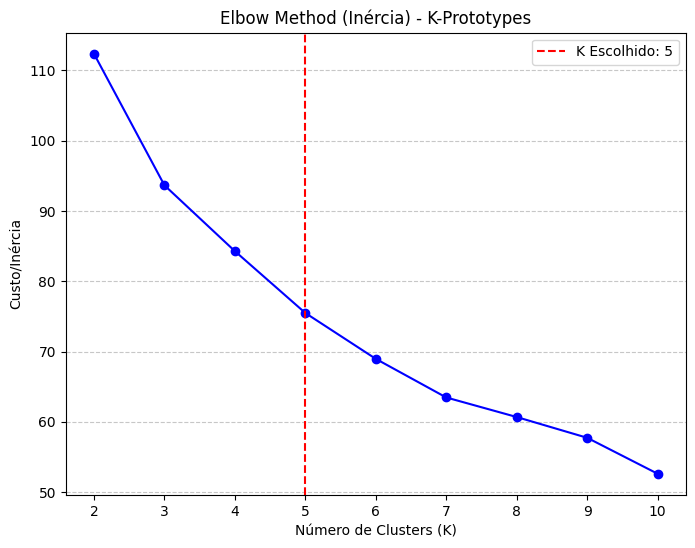


EXECUTANDO K-PROTOTYPES FINAL COM K=5

--- QUANTIDADE DE ELEMENTOS POR CLUSTER ---
Cluster_Final
0     46
1    100
2    203
3    123
4    419
-------------------------------------

--- ATRIBUTOS FINAIS ---
Custo Final: 74.6124
Gamma Final Usado: 0.0666

Protótipos dos Clusters (Centroides e Modos):


,Age,Fare,SibSp,Parch,Sex,Embarked,Pclass,Cabin
Cluster,,,,,,,,
0,0.16490925183299246,0.0838802006345852,0.5135869565217391,0.3224637681159422,male,S,3,0
1,0.3676702689117865,0.22855250881659683,0.06125,0.09000000000000005,female,C,1,1
2,0.32131374444899696,0.0360694549039357,0.06096059113300493,0.10262725779967168,female,S,3,0
3,0.584352402961074,0.09175455588200346,0.039634146341463415,0.03387533875338755,male,S,1,1
4,0.3402940017430412,0.02550169268869015,0.02684964200477327,0.01869530628480512,male,S,3,0


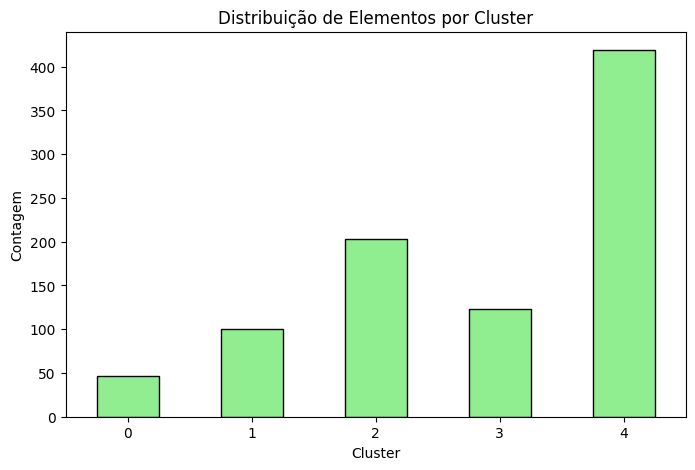


Distribuição da Pclass (%) em cada Cluster:


Pclass,1,2,3
Cluster_Final,,,
0,2.2,4.3,93.5
1,97.0,2.0,1.0
2,2.0,35.0,63.1
3,81.3,14.6,4.1
4,3.3,21.7,74.9



Distribuição do Sexo (%) em cada Cluster:


Sex,female,male
Cluster_Final,,
0,34.8,65.2
1,80.0,20.0
2,100.0,0.0
3,12.2,87.8
4,0.0,100.0



Distribuição de Embarked (%) em cada Cluster:


Embarked,C,Q,S
Cluster_Final,,,
0,0.0,8.7,91.3
1,62.0,2.0,36.0
2,13.8,16.7,69.5
3,17.1,3.3,79.7
4,13.6,7.9,78.5



Distribuição de Cabin (%) em cada Cluster:


Cabin,0,1
Cluster_Final,,
0,95.7,4.3
1,12.0,88.0
2,94.6,5.4
3,22.0,78.0
4,98.3,1.7


In [ ]:
# ==============================================================================
# 2. CÁLCULO DA MÉTRICA (ELBOW)
# ==============================================================================
print("\n" + "="*60)
print(f" CALCULANDO INÉRCIA PARA ELBOW METHOD")
print("="*60)

inertias = []
K_range = range(2, 11)

for k in K_range:
    # gamma=None deixa a biblioteca calcular automaticamente
    kproto = KPrototypes(n_clusters=k, n_init=10, random_state=42)
    kproto.fit(data_array, categorical=categorical_indices)

    inertias.append(kproto.cost_)

# ==============================================================================
# 3. LÓGICA DE SELEÇÃO: APENAS ELBOW (KNEED) E PLOTAGEM
# ==============================================================================

# A. Melhor K para Elbow (USANDO KNEED)
k_elbow_locator = KneeLocator(
    x=list(K_range),
    y=inertias,
    curve="convex",
    direction="decreasing"
)
best_k_elbow = k_elbow_locator.elbow

# Fallback
if best_k_elbow is None:
    best_k_elbow = 3

vencedor_k = best_k_elbow

print(f"\n>>> VALOR DE K ESCOLHIDO (ELBOW): {vencedor_k}")

# Plotagem Gráfica
plt.figure(figsize=(8, 6))
plt.plot(K_range, inertias, 'bo-')
plt.title(f'Elbow Method (Inércia) - K-Prototypes')
plt.xlabel('Número de Clusters (K)')
plt.ylabel('Custo/Inércia')

plt.xticks(K_range, rotation=0)

if vencedor_k:
    plt.axvline(x=vencedor_k, color='r', linestyle='--', label=f'K Escolhido: {vencedor_k}')
    plt.legend()

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# ==============================================================================
# 4. RODADA FINAL COM O K VENCEDOR
# ==============================================================================
print("\n" + "="*60)
print(f"EXECUTANDO K-PROTOTYPES FINAL COM K={vencedor_k}")
print("="*60)

model_final = KPrototypes(n_clusters=vencedor_k, n_init=100, random_state=42)
model_final.fit(data_array, categorical=categorical_indices)

# Adiciona o rótulo do cluster ao DataFrame
df_resultado = df_final.copy()
df_resultado['Cluster_Final'] = model_final.labels_

# --- NOVO REQUISITO: Imprimir contagem de elementos por cluster no console ---
print("\n--- QUANTIDADE DE ELEMENTOS POR CLUSTER ---")
counts = df_resultado['Cluster_Final'].value_counts().sort_index()
print(counts.to_string())
print("-" * 37)
# ----------------------------------------------------------------------------

# ==============================================================================
# 5. ANÁLISE DOS PROTÓTIPOS (CENTROIDES)
# ==============================================================================
print("\n--- ATRIBUTOS FINAIS ---")
print(f"Custo Final: {model_final.cost_:.4f}")
print(f"Gamma Final Usado: {model_final.gamma:.4f}") # Confirmação do gamma final

# A. Protótipos Numéricos
prototypes_num = model_final.cluster_centroids_[:, :len(numeric_cols)]
prototypes_num_df = pd.DataFrame(prototypes_num, columns=numeric_cols)

# B. Protótipos Categóricos
prototypes_cat = model_final.cluster_centroids_[:, len(numeric_cols):]
prototypes_cat_df = pd.DataFrame(prototypes_cat, columns=categorical_cols)

# C. Combinando e Exibindo
centroides_df = pd.concat([prototypes_num_df, prototypes_cat_df], axis=1)
centroides_df.index.name = 'Cluster'
print("\nProtótipos dos Clusters (Centroides e Modos):")
display(centroides_df)

# ==============================================================================
# 6. ANÁLISE DE DISTRIBUIÇÃO
# ==============================================================================

# Contagem (A contagem em console foi adicionada logo após o K-Prototypes final)
plt.figure(figsize=(8, 5))
counts.plot(kind='bar', color='lightgreen', edgecolor='black', rot=0) # rot=0 para garantir os rótulos retos
plt.title('Distribuição de Elementos por Cluster')
plt.xlabel('Cluster')
plt.ylabel('Contagem')
plt.show()

plt.xticks(K_range, rotation=0)

# Análise de Pclass
print("\nDistribuição da Pclass (%) em cada Cluster:")
pclass_by_cluster = pd.crosstab(df_resultado['Cluster_Final'], df_resultado['Pclass'], normalize='index') * 100
display(pclass_by_cluster.round(1))

# Análise de Sex
print("\nDistribuição do Sexo (%) em cada Cluster:")
sex_by_cluster = pd.crosstab(df_resultado['Cluster_Final'], df_resultado['Sex'], normalize='index') * 100
display(sex_by_cluster.round(1))

# Análise de Embarked
print("\nDistribuição de Embarked (%) em cada Cluster:")
embarked_by_cluster = pd.crosstab(df_resultado['Cluster_Final'], df_resultado['Embarked'], normalize='index') * 100
display(embarked_by_cluster.round(1))

# Análise de Cabin
print("\nDistribuição de Cabin (%) em cada Cluster:")
cabin_by_cluster = pd.crosstab(df_resultado['Cluster_Final'], df_resultado['Cabin'], normalize='index') * 100
display(cabin_by_cluster.round(1))


 ANÁLISE NUMÉRICA DETALHADA (VALORES ORIGINAIS)

>>> Média das Variáveis por Cluster (Escala Real):


,Age,Fare,SibSp,Parch
Cluster_Final,,,,
0,13.54,42.97,4.11,1.93
1,29.68,117.09,0.49,0.54
2,25.99,18.48,0.49,0.62
3,46.92,47.01,0.32,0.20
4,27.50,13.07,0.21,0.11



>>> Mediana das Variáveis por Cluster (Escala Real) - (Mais robusto a outliers):


,Age,Fare,SibSp,Parch
Cluster_Final,,,,
0,9.0,31.39,4.0,2.0
1,28.0,84.99,0.0,0.0
2,28.0,14.45,0.0,0.0
3,48.0,33.50,0.0,0.0
4,28.0,8.05,0.0,0.0



>>> Distribuição Visual (Boxplots):


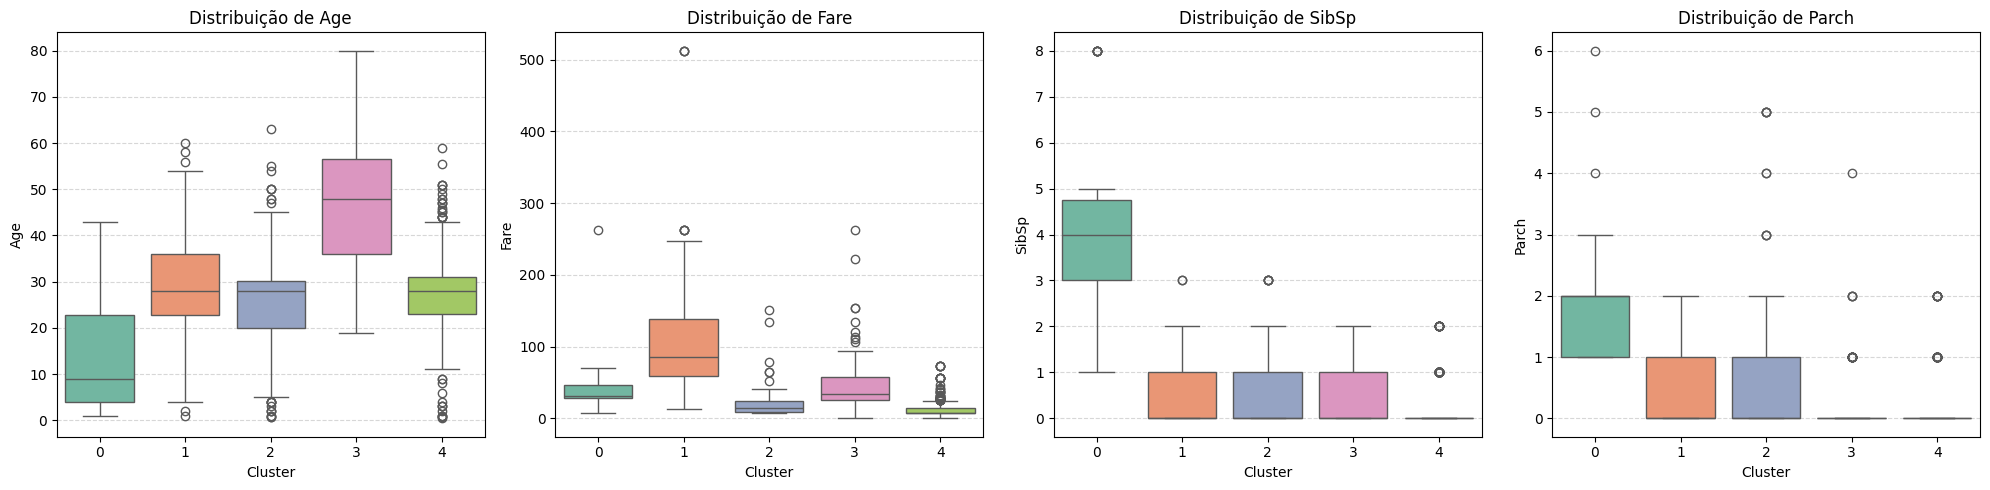

In [ ]:
# ==============================================================================
# 7. ANÁLISE DAS VARIÁVEIS NUMÉRICAS (ESCALA ORIGINAL)
# ==============================================================================
print("\n" + "="*60)
print(" ANÁLISE NUMÉRICA DETALHADA (VALORES ORIGINAIS)")
print("="*60)

# Limpa qualquer gráfico "fantasma" que tenha ficado na memória
plt.close('all')

# 1. Recuperamos os dados originais (antes da normalização)
df_analysis = df[numeric_cols].copy()
df_analysis['Cluster_Final'] = model_final.labels_

# ------------------------------------------------------------------------------
# A. TABELA DE MÉDIAS E MEDIANAS
# ------------------------------------------------------------------------------
print("\n>>> Média das Variáveis por Cluster (Escala Real):")
numeric_means = df_analysis.groupby('Cluster_Final')[numeric_cols].mean()
display(numeric_means.round(2))

print("\n>>> Mediana das Variáveis por Cluster (Escala Real) - (Mais robusto a outliers):")
numeric_medians = df_analysis.groupby('Cluster_Final')[numeric_cols].median()
display(numeric_medians.round(2))

# ------------------------------------------------------------------------------
# B. VISUALIZAÇÃO COM BOXPLOTS
# ------------------------------------------------------------------------------
print("\n>>> Distribuição Visual (Boxplots):")

# Configura o tamanho da figura
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# Cores
palette = sns.color_palette("Set2", n_colors=vencedor_k)

for i, col in enumerate(numeric_cols):
    # AJUSTE AQUI: Adicionado hue=... e legend=False para corrigir o Warning e garantir a cor correta
    sns.boxplot(
        x='Cluster_Final',
        y=col,
        data=df_analysis,
        ax=axes[i],
        palette=palette,
        hue='Cluster_Final',
        legend=False
    )

    axes[i].set_title(f'Distribuição de {col}', fontsize=12)
    axes[i].set_xlabel('Cluster')
    axes[i].set_ylabel(col)
    axes[i].grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

# ------------------------------------------------------------------------------
# C. INTERPRETAÇÃO AUTOMÁTICA SIMPLES
# ------------------------------------------------------------------------------
# print("\n--- RESUMO RÁPIDO ---")
# Recalcula counts caso não esteja na memória
#c ounts = df_analysis['Cluster_Final'].value_counts().sort_index()

# for cluster_id in range(vencedor_k):
#     n_elem = counts[cluster_id]
#    avg_age = numeric_means.loc[cluster_id, 'Age']
#    avg_fare = numeric_means.loc[cluster_id, 'Fare']
#    print(f"Cluster {cluster_id} ({n_elem} pessoas): Média Idade={avg_age:.1f} anos | Média Tarifa=${avg_fare:.2f}")'''

# Rodando novamente o K-Prototypes, mas agora sem a variável Cabin.

Observe que copiei todo o código novamente, com a única alteração tendo sido na parte de tratamento dos dados

In [ ]:
!pip install -q kmodes # Inclui k-prototypes e k-modes
!pip install -q kneed

from google.colab import files
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from sklearn.preprocessing import MinMaxScaler
from kmodes.kprototypes import KPrototypes
# from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from kneed import KneeLocator
from collections import Counter


# ==============================================================================
# 1. CARREGAMENTO E PRÉ-PROCESSAMENTO OTIMIZADO PARA K-PROTOTYPES
# ==============================================================================
print("\n--- INICIANDO PRÉ-PROCESSAMENTO PARA K-PROTOTYPES ---")

try:
    # Tentativa de carregar o arquivo, caso não tenha sido executado
    df = pd.read_csv('train.csv')
    df.drop(columns=['Survived'], inplace=True) # Remove a coluna alvo, como feito
except FileNotFoundError:
    print("ERRO: O arquivo 'train.csv' não foi encontrado. Certifique-se de que a célula de download de dados foi executada.")
    # Usar a cópia do df do notebook para continuar
    df = pd.DataFrame(df)

# A. TRATAMENTO DE VALORES FALTANTES (Igual ao seu)
# ------------------------------------------------------------------------------
mediana_age = df['Age'].median()
df['Age'].fillna(mediana_age, inplace=True)

moda_embarked = df['Embarked'].mode()[0]
df['Embarked'].fillna(moda_embarked, inplace=True)

print("1. Nulos em 'Age' (Mediana) e 'Embarked' (Moda) preenchidos.")

# B. FEATURE ENGINEERING: CABIN (AGORA CATEGÓRICA)
# ------------------------------------------------------------------------------
# 0 se nulo, 1 se valor. O importante é o .astype(str) no final.
# df['Cabin'] = df['Cabin'].notna().astype(int).astype(str)
# print("1. 'Cabin' transformada em binária e mantida como Categórica ('0' ou '1').")


# C. REMOÇÃO DE COLUNAS DESNECESSÁRIAS (Igual ao seu)
# ------------------------------------------------------------------------------
cols_to_drop = ['PassengerId', 'Name', 'Ticket', 'Cabin']
cols_present = [c for c in cols_to_drop if c in df.columns]
df.drop(columns=cols_present, inplace=True)
print(f"3. Colunas removidas: {cols_present}")


# D. SEPARAÇÃO E IDENTIFICAÇÃO DE TIPOS
# ------------------------------------------------------------------------------
# Pclass é numérica (int64) no original, mas é CATEGÓRICA para agrupamento
df['Pclass'] = df['Pclass'].astype(str)

numeric_cols = ['Age', 'Fare', 'SibSp', 'Parch']
categorical_cols = ['Sex', 'Embarked', 'Pclass'] # Deixamos como string/object

# O DataFrame final terá a ORDEM correta para o KPrototypes: Numéricas + Categóricas
df_final = df[numeric_cols + categorical_cols].copy()

print("\n4. Colunas categóricas mantidas como string (sem One-Hot Encoding):")
print(f"   {categorical_cols}")


# E. NORMALIZAÇÃO SELETIVA (APENAS FEATURES CONTÍNUAS)
# ------------------------------------------------------------------------------
# Normaliza apenas Age, Fare, SibSp, Parch
cols_to_normalize = ['Age', 'Fare', 'SibSp', 'Parch']
print(f"\n5. Normalizando apenas: {cols_to_normalize}")

scaler = MinMaxScaler()
df_final[cols_to_normalize] = scaler.fit_transform(df_final[cols_to_normalize])

'''# F. CÁLCULO DINÂMICO DE GAMMA (NOVO PASSO)
# ==============================================================================

# Calcula o desvio padrão de cada feature numérica
std_devs = df_final[numeric_cols].std()

# Calcula gamma como a média desses desvios padrão
gamma = std_devs.mean()

print(f"\nDesvios Padrão (Numéricas):")
print(std_devs)
print(f"\n>>> GAMMA CALCULADO (MÉDIA DOS DESVIOS PADRÃO): {gamma:.4f}")'''

# G. ÍNDICES DAS COLUNAS CATEGÓRICAS
# ------------------------------------------------------------------------------
# O KPrototypes precisa dos *índices* das colunas categóricas no array NumPy
# As colunas categóricas estão após as numéricas.
num_features = len(numeric_cols)
# Os índices categóricos começam no número de colunas numéricas
categorical_indices = [df_final.columns.get_loc(col) for col in categorical_cols]

# print(f"\nColunas numéricas ({len(numeric_cols)}): {list(numeric_cols)}")
# print(f"Colunas categóricas ({len(categorical_cols)}): {list(categorical_cols)}")
# print(f"Índices Categóricos no Array Final (necessário para KPrototypes): {categorical_indices}")

# Converte para array numpy, que é o que o KPrototypes espera
data_array = df_final.values

print("\n--- DATASET FINAL PRONTO PARA K-PROTOTYPES ---")
print(f"Shape final: {data_array.shape}")
display(df_final.head())



--- INICIANDO PRÉ-PROCESSAMENTO PARA K-PROTOTYPES ---
1. Nulos em 'Age' (Mediana) e 'Embarked' (Moda) preenchidos.
3. Colunas removidas: ['PassengerId', 'Name', 'Ticket', 'Cabin']

4. Colunas categóricas mantidas como string (sem One-Hot Encoding):
   ['Sex', 'Embarked', 'Pclass']

5. Normalizando apenas: ['Age', 'Fare', 'SibSp', 'Parch']

--- DATASET FINAL PRONTO PARA K-PROTOTYPES ---
Shape final: (891, 7)


/tmp/ipython-input-2223424981.py:34: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Age'].fillna(mediana_age, inplace=True)
/tmp/ipython-input-2223424981.py:37: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using

,Age,Fare,SibSp,Parch,Sex,Embarked,Pclass
0,0.271174,0.014151,0.125,0.0,male,S,3
1,0.472229,0.139136,0.125,0.0,female,C,1
2,0.321438,0.015469,0.000,0.0,female,S,3
3,0.434531,0.103644,0.125,0.0,female,S,1
4,0.434531,0.015713,0.000,0.0,male,S,3



 CALCULANDO INÉRCIA PARA ELBOW METHOD

>>> VALOR DE K ESCOLHIDO (ELBOW): 5


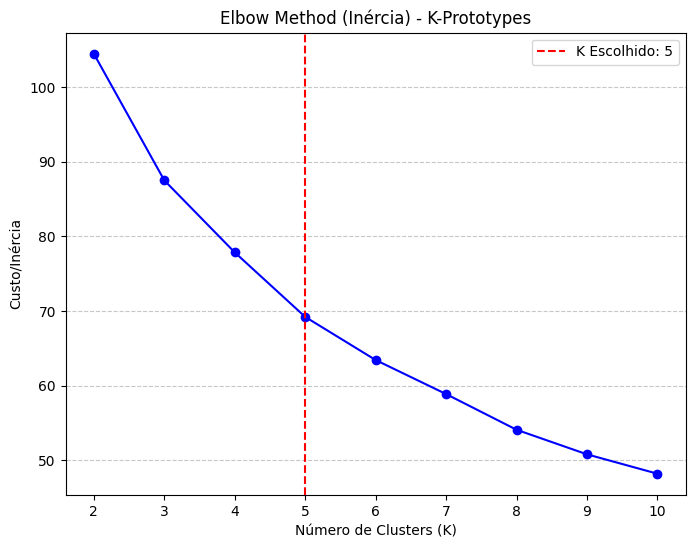


EXECUTANDO K-PROTOTYPES FINAL COM K=5

--- QUANTIDADE DE ELEMENTOS POR CLUSTER ---
Cluster_Final
0    389
1     70
2    185
3    151
4     96
-------------------------------------

--- ATRIBUTOS FINAIS ---
Custo Final: 68.7388
Gamma Final Usado: 0.0666

Protótipos dos Clusters (Centroides e Modos):


,Age,Fare,SibSp,Parch,Sex,Embarked,Pclass
Cluster,,,,,,,
0,0.3268402687373493,0.024973727679154636,0.02731362467866324,0.019280205655527096,male,S,3
1,0.19387857681398746,0.09960102382831765,0.4035714285714286,0.3500000000000001,female,S,3
2,0.31189420131365314,0.034997163247085405,0.0472972972972973,0.072972972972973,female,S,3
3,0.5823270847445778,0.07901529921213285,0.03559602649006623,0.03421633554083885,male,S,1
4,0.39264471810337614,0.21785647864042623,0.0546875,0.06250000000000001,female,C,1


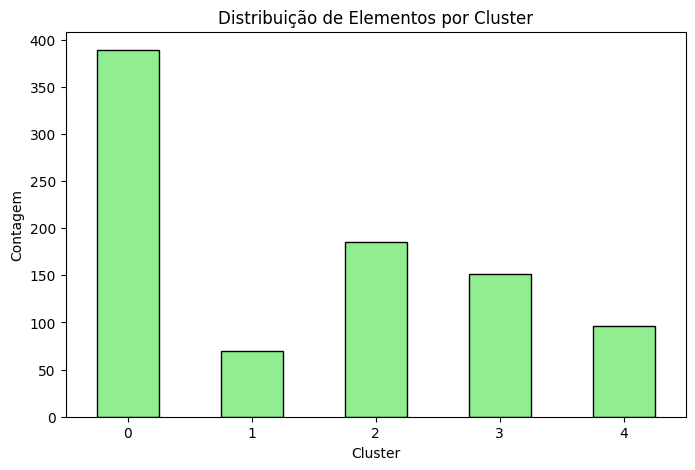


Distribuição da Pclass (%) em cada Cluster:


Pclass,1,2,3
Cluster_Final,,,
0,0.8,20.3,78.9
1,10.0,7.1,82.9
2,6.5,32.4,61.1
3,69.5,21.9,8.6
4,92.7,7.3,0.0



Distribuição do Sexo (%) em cada Cluster:


Sex,female,male
Cluster_Final,,
0,0.0,100.0
1,54.3,45.7
2,100.0,0.0
3,11.9,88.1
4,76.0,24.0



Distribuição de Embarked (%) em cada Cluster:


Embarked,C,Q,S
Cluster_Final,,,
0,13.4,8.5,78.1
1,5.7,7.1,87.1
2,10.8,18.4,70.8
3,13.2,2.6,84.1
4,75.0,1.0,24.0


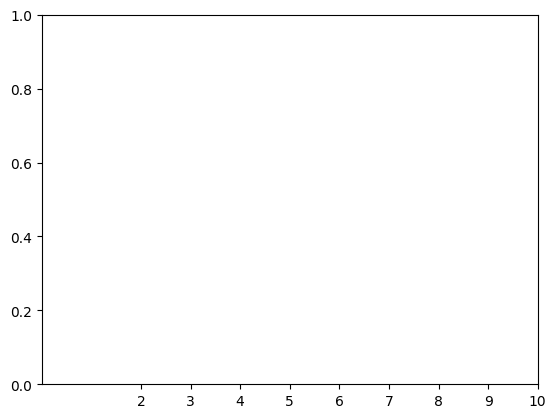

In [ ]:
# ==============================================================================
# 2. CÁLCULO DA MÉTRICA (ELBOW)
# ==============================================================================
print("\n" + "="*60)
print(f" CALCULANDO INÉRCIA PARA ELBOW METHOD")
print("="*60)

inertias = []
K_range = range(2, 11)

for k in K_range:
    # gamma=None deixa a biblioteca calcular automaticamente
    kproto = KPrototypes(n_clusters=k, n_init=10, random_state=42)
    kproto.fit(data_array, categorical=categorical_indices)

    inertias.append(kproto.cost_)

# ==============================================================================
# 3. LÓGICA DE SELEÇÃO: APENAS ELBOW (KNEED) E PLOTAGEM
# ==============================================================================

# A. Melhor K para Elbow (USANDO KNEED)
k_elbow_locator = KneeLocator(
    x=list(K_range),
    y=inertias,
    curve="convex",
    direction="decreasing"
)
best_k_elbow = k_elbow_locator.elbow

# Fallback
if best_k_elbow is None:
    best_k_elbow = 3

vencedor_k = best_k_elbow

print(f"\n>>> VALOR DE K ESCOLHIDO (ELBOW): {vencedor_k}")

# Plotagem Gráfica
plt.figure(figsize=(8, 6))
plt.plot(K_range, inertias, 'bo-')
plt.title(f'Elbow Method (Inércia) - K-Prototypes')
plt.xlabel('Número de Clusters (K)')
plt.ylabel('Custo/Inércia')

plt.xticks(K_range, rotation=0)

if vencedor_k:
    plt.axvline(x=vencedor_k, color='r', linestyle='--', label=f'K Escolhido: {vencedor_k}')
    plt.legend()

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# ==============================================================================
# 4. RODADA FINAL COM O K VENCEDOR
# ==============================================================================
print("\n" + "="*60)
print(f"EXECUTANDO K-PROTOTYPES FINAL COM K={vencedor_k}")
print("="*60)

model_final = KPrototypes(n_clusters=vencedor_k, n_init=100, random_state=42)
model_final.fit(data_array, categorical=categorical_indices)

# Adiciona o rótulo do cluster ao DataFrame
df_resultado = df_final.copy()
df_resultado['Cluster_Final'] = model_final.labels_

# --- NOVO REQUISITO: Imprimir contagem de elementos por cluster no console ---
print("\n--- QUANTIDADE DE ELEMENTOS POR CLUSTER ---")
counts = df_resultado['Cluster_Final'].value_counts().sort_index()
print(counts.to_string())
print("-" * 37)
# ----------------------------------------------------------------------------

# ==============================================================================
# 5. ANÁLISE DOS PROTÓTIPOS (CENTROIDES)
# ==============================================================================
print("\n--- ATRIBUTOS FINAIS ---")
print(f"Custo Final: {model_final.cost_:.4f}")
print(f"Gamma Final Usado: {model_final.gamma:.4f}") # Confirmação do gamma final

# A. Protótipos Numéricos
prototypes_num = model_final.cluster_centroids_[:, :len(numeric_cols)]
prototypes_num_df = pd.DataFrame(prototypes_num, columns=numeric_cols)

# B. Protótipos Categóricos
prototypes_cat = model_final.cluster_centroids_[:, len(numeric_cols):]
prototypes_cat_df = pd.DataFrame(prototypes_cat, columns=categorical_cols)

# C. Combinando e Exibindo
centroides_df = pd.concat([prototypes_num_df, prototypes_cat_df], axis=1)
centroides_df.index.name = 'Cluster'
print("\nProtótipos dos Clusters (Centroides e Modos):")
display(centroides_df)

# ==============================================================================
# 6. ANÁLISE DE DISTRIBUIÇÃO
# ==============================================================================

# Contagem (A contagem em console foi adicionada logo após o K-Prototypes final)
plt.figure(figsize=(8, 5))
counts.plot(kind='bar', color='lightgreen', edgecolor='black', rot=0) # rot=0 para garantir os rótulos retos
plt.title('Distribuição de Elementos por Cluster')
plt.xlabel('Cluster')
plt.ylabel('Contagem')
plt.show()

plt.xticks(K_range, rotation=0)

# Análise de Pclass
print("\nDistribuição da Pclass (%) em cada Cluster:")
pclass_by_cluster = pd.crosstab(df_resultado['Cluster_Final'], df_resultado['Pclass'], normalize='index') * 100
display(pclass_by_cluster.round(1))

# Análise de Sex
print("\nDistribuição do Sexo (%) em cada Cluster:")
sex_by_cluster = pd.crosstab(df_resultado['Cluster_Final'], df_resultado['Sex'], normalize='index') * 100
display(sex_by_cluster.round(1))

# Análise de Embarked
print("\nDistribuição de Embarked (%) em cada Cluster:")
embarked_by_cluster = pd.crosstab(df_resultado['Cluster_Final'], df_resultado['Embarked'], normalize='index') * 100
display(embarked_by_cluster.round(1))

# Análise de Cabin
# print("\nDistribuição de Cabin (%) em cada Cluster:")
# cabin_by_cluster = pd.crosstab(df_resultado['Cluster_Final'], df_resultado['Cabin'], normalize='index') * 100
# display(cabin_by_cluster.round(1))


 ANÁLISE NUMÉRICA DETALHADA (VALORES ORIGINAIS)

>>> Média das Variáveis por Cluster (Escala Real):


,Age,Fare,SibSp,Parch
Cluster_Final,,,,
0,26.43,12.79,0.22,0.12
1,15.85,51.03,3.23,2.10
2,25.24,17.93,0.38,0.44
3,46.76,40.48,0.28,0.21
4,31.67,111.61,0.44,0.38



>>> Mediana das Variáveis por Cluster (Escala Real) - (Mais robusto a outliers):


,Age,Fare,SibSp,Parch
Cluster_Final,,,,
0,28.0,8.05,0.0,0.0
1,11.0,31.39,3.0,2.0
2,28.0,13.00,0.0,0.0
3,48.0,27.72,0.0,0.0
4,29.5,83.16,0.0,0.0



>>> Distribuição Visual (Boxplots):


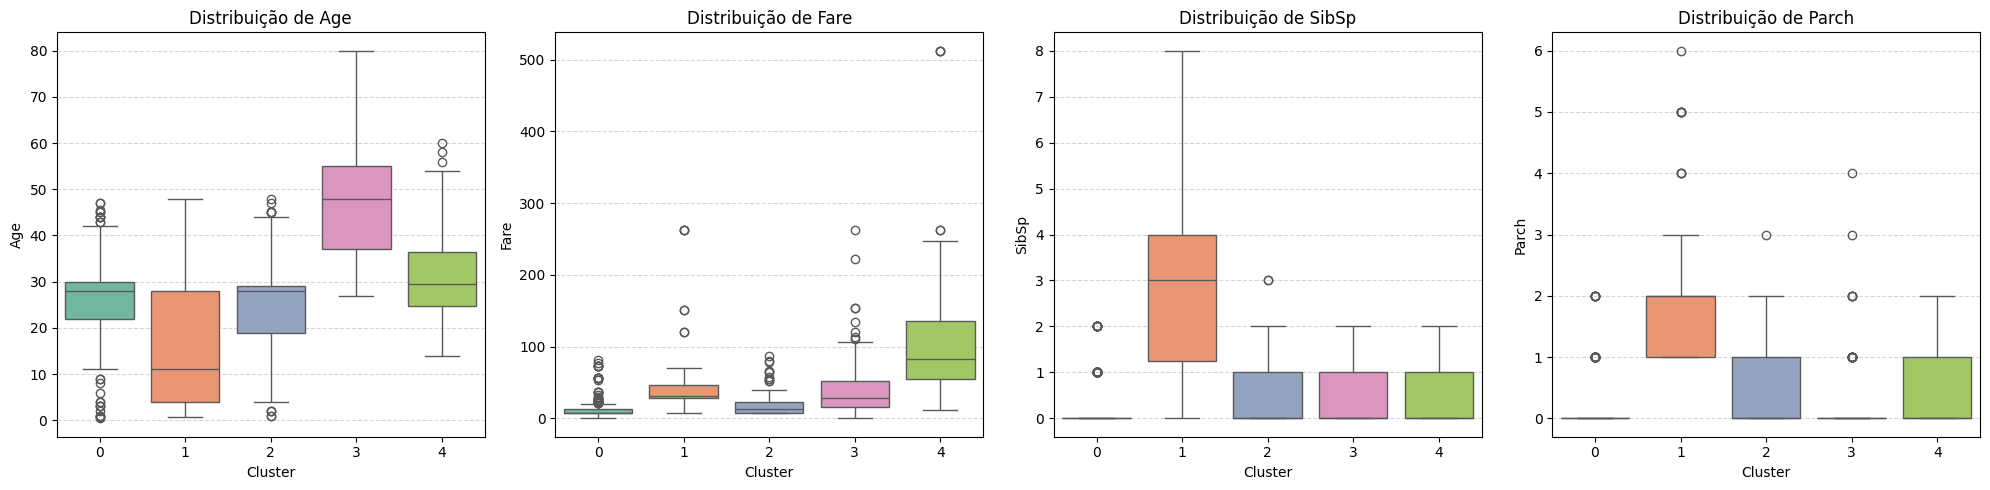

In [ ]:
# ==============================================================================
# 7. ANÁLISE DAS VARIÁVEIS NUMÉRICAS (ESCALA ORIGINAL)
# ==============================================================================
print("\n" + "="*60)
print(" ANÁLISE NUMÉRICA DETALHADA (VALORES ORIGINAIS)")
print("="*60)

# Limpa qualquer gráfico "fantasma" que tenha ficado na memória
plt.close('all')

# 1. Recuperamos os dados originais (antes da normalização)
df_analysis = df[numeric_cols].copy()
df_analysis['Cluster_Final'] = model_final.labels_

# ------------------------------------------------------------------------------
# A. TABELA DE MÉDIAS E MEDIANAS
# ------------------------------------------------------------------------------
print("\n>>> Média das Variáveis por Cluster (Escala Real):")
numeric_means = df_analysis.groupby('Cluster_Final')[numeric_cols].mean()
display(numeric_means.round(2))

print("\n>>> Mediana das Variáveis por Cluster (Escala Real) - (Mais robusto a outliers):")
numeric_medians = df_analysis.groupby('Cluster_Final')[numeric_cols].median()
display(numeric_medians.round(2))

# ------------------------------------------------------------------------------
# B. VISUALIZAÇÃO COM BOXPLOTS
# ------------------------------------------------------------------------------
print("\n>>> Distribuição Visual (Boxplots):")

# Configura o tamanho da figura
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# Cores
palette = sns.color_palette("Set2", n_colors=vencedor_k)

for i, col in enumerate(numeric_cols):
    # AJUSTE AQUI: Adicionado hue=... e legend=False para corrigir o Warning e garantir a cor correta
    sns.boxplot(
        x='Cluster_Final',
        y=col,
        data=df_analysis,
        ax=axes[i],
        palette=palette,
        hue='Cluster_Final',
        legend=False
    )

    axes[i].set_title(f'Distribuição de {col}', fontsize=12)
    axes[i].set_xlabel('Cluster')
    axes[i].set_ylabel(col)
    axes[i].grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

# ------------------------------------------------------------------------------
# C. INTERPRETAÇÃO AUTOMÁTICA SIMPLES
# ------------------------------------------------------------------------------
# print("\n--- RESUMO RÁPIDO ---")
# Recalcula counts caso não esteja na memória
#c ounts = df_analysis['Cluster_Final'].value_counts().sort_index()

# for cluster_id in range(vencedor_k):
#     n_elem = counts[cluster_id]
#    avg_age = numeric_means.loc[cluster_id, 'Age']
#    avg_fare = numeric_means.loc[cluster_id, 'Fare']
#    print(f"Cluster {cluster_id} ({n_elem} pessoas): Média Idade={avg_age:.1f} anos | Média Tarifa=${avg_fare:.2f}")'''

# Rodando novamente o K-Prototypes, mas agora sem a variável Cabin e com Family.

Observe que copiei todo o código novamente, com a única alteração tendo sido na parte de tratamento dos dados

In [ ]:
!pip install -q kmodes # Inclui k-prototypes e k-modes
!pip install -q kneed

from google.colab import files
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from sklearn.preprocessing import MinMaxScaler
from kmodes.kprototypes import KPrototypes
# from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from kneed import KneeLocator
from collections import Counter


# ==============================================================================
# 1. CARREGAMENTO E PRÉ-PROCESSAMENTO OTIMIZADO PARA K-PROTOTYPES
# ==============================================================================
print("\n--- INICIANDO PRÉ-PROCESSAMENTO PARA K-PROTOTYPES ---")

try:
    # Tentativa de carregar o arquivo, caso não tenha sido executado
    df = pd.read_csv('train.csv')
    df.drop(columns=['Survived'], inplace=True) # Remove a coluna alvo, como feito
except FileNotFoundError:
    print("ERRO: O arquivo 'train.csv' não foi encontrado. Certifique-se de que a célula de download de dados foi executada.")
    # Usar a cópia do df do notebook para continuar
    df = pd.DataFrame(df)

# A. TRATAMENTO DE VALORES FALTANTES (Igual ao seu)
# ------------------------------------------------------------------------------
mediana_age = df['Age'].median()
df['Age'].fillna(mediana_age, inplace=True)

moda_embarked = df['Embarked'].mode()[0]
df['Embarked'].fillna(moda_embarked, inplace=True)

print("1. Nulos em 'Age' (Mediana) e 'Embarked' (Moda) preenchidos.")

# B. FEATURE ENGINEERING: CABIN (AGORA CATEGÓRICA)
# ------------------------------------------------------------------------------
# 0 se nulo, 1 se valor. O importante é o .astype(str) no final.
# df['Cabin'] = df['Cabin'].notna().astype(int).astype(str)
# print("1. 'Cabin' transformada em binária e mantida como Categórica ('0' ou '1').")


# C. REMOÇÃO DE COLUNAS DESNECESSÁRIAS (Igual ao seu)
# ------------------------------------------------------------------------------
cols_to_drop = ['PassengerId', 'Name', 'Ticket', 'Cabin']
cols_present = [c for c in cols_to_drop if c in df.columns]
df.drop(columns=cols_present, inplace=True)
print(f"3. Colunas removidas: {cols_present}")


# D. SEPARAÇÃO E IDENTIFICAÇÃO DE TIPOS
# ------------------------------------------------------------------------------
# Pclass é numérica (int64) no original, mas é CATEGÓRICA para agrupamento
df['Pclass'] = df['Pclass'].astype(str)

df['Family'] = df['SibSp'] + df['Parch']
df.drop(columns=['SibSp', 'Parch'], inplace=True)

numeric_cols = ['Age', 'Fare', 'Family']
categorical_cols = ['Sex', 'Embarked', 'Pclass'] # Deixamos como string/object

# O DataFrame final terá a ORDEM correta para o KPrototypes: Numéricas + Categóricas
df_final = df[numeric_cols + categorical_cols].copy()

print("\n4. Colunas categóricas mantidas como string (sem One-Hot Encoding):")
print(f"   {categorical_cols}")


# E. NORMALIZAÇÃO SELETIVA (APENAS FEATURES CONTÍNUAS)
# ------------------------------------------------------------------------------
# Normaliza apenas Age, Fare, SibSp, Parch
cols_to_normalize = ['Age', 'Fare', 'Family']
print(f"\n5. Normalizando apenas: {cols_to_normalize}")

scaler = MinMaxScaler()
df_final[cols_to_normalize] = scaler.fit_transform(df_final[cols_to_normalize])

'''# F. CÁLCULO DINÂMICO DE GAMMA (NOVO PASSO)
# ==============================================================================

# Calcula o desvio padrão de cada feature numérica
std_devs = df_final[numeric_cols].std()

# Calcula gamma como a média desses desvios padrão
gamma = std_devs.mean()

print(f"\nDesvios Padrão (Numéricas):")
print(std_devs)
print(f"\n>>> GAMMA CALCULADO (MÉDIA DOS DESVIOS PADRÃO): {gamma:.4f}")'''

# G. ÍNDICES DAS COLUNAS CATEGÓRICAS
# ------------------------------------------------------------------------------
# O KPrototypes precisa dos *índices* das colunas categóricas no array NumPy
# As colunas categóricas estão após as numéricas.
num_features = len(numeric_cols)
# Os índices categóricos começam no número de colunas numéricas
categorical_indices = [df_final.columns.get_loc(col) for col in categorical_cols]

# print(f"\nColunas numéricas ({len(numeric_cols)}): {list(numeric_cols)}")
# print(f"Colunas categóricas ({len(categorical_cols)}): {list(categorical_cols)}")
# print(f"Índices Categóricos no Array Final (necessário para KPrototypes): {categorical_indices}")

# Converte para array numpy, que é o que o KPrototypes espera
data_array = df_final.values

print("\n--- DATASET FINAL PRONTO PARA K-PROTOTYPES ---")
print(f"Shape final: {data_array.shape}")
display(df_final.head())



--- INICIANDO PRÉ-PROCESSAMENTO PARA K-PROTOTYPES ---
1. Nulos em 'Age' (Mediana) e 'Embarked' (Moda) preenchidos.
3. Colunas removidas: ['PassengerId', 'Name', 'Ticket', 'Cabin']

4. Colunas categóricas mantidas como string (sem One-Hot Encoding):
   ['Sex', 'Embarked', 'Pclass']

5. Normalizando apenas: ['Age', 'Fare', 'Family']

--- DATASET FINAL PRONTO PARA K-PROTOTYPES ---
Shape final: (891, 6)


/tmp/ipython-input-1943151030.py:34: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Age'].fillna(mediana_age, inplace=True)
/tmp/ipython-input-1943151030.py:37: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using

,Age,Fare,Family,Sex,Embarked,Pclass
0,0.271174,0.014151,0.1,male,S,3
1,0.472229,0.139136,0.1,female,C,1
2,0.321438,0.015469,0.0,female,S,3
3,0.434531,0.103644,0.1,female,S,1
4,0.434531,0.015713,0.0,male,S,3



 CALCULANDO INÉRCIA PARA ELBOW METHOD

>>> VALOR DE K ESCOLHIDO (ELBOW): 6


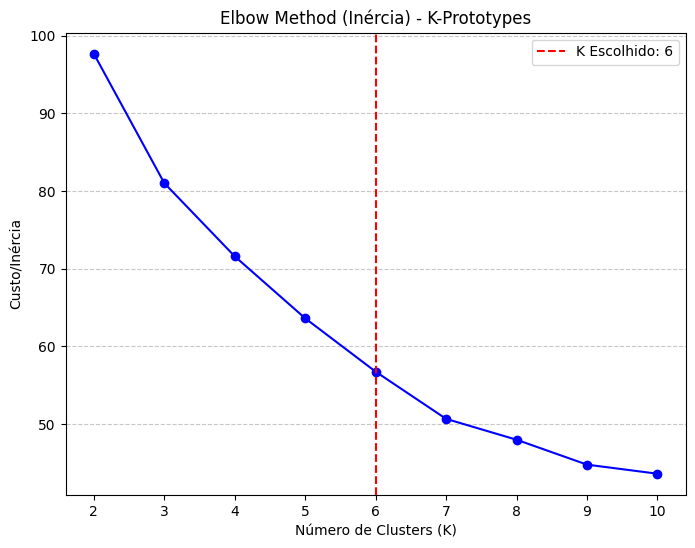


EXECUTANDO K-PROTOTYPES FINAL COM K=6

--- QUANTIDADE DE ELEMENTOS POR CLUSTER ---
Cluster_Final
0     54
1    163
2     96
3    128
4    138
5    312
-------------------------------------

--- ATRIBUTOS FINAIS ---
Custo Final: 53.9531
Gamma Final Usado: 0.0703

Protótipos dos Clusters (Centroides e Modos):


,Age,Fare,Family,Sex,Embarked,Pclass
Cluster,,,,,,
0,0.19855165545037348,0.10528049586520206,0.5870370370370361,male,S,3
1,0.27221440168245176,0.03870914712721447,0.11411042944785255,female,S,3
2,0.39526262880120616,0.21730497370310597,0.07916666666666664,female,C,1
3,0.586550091103292,0.08714610705870368,0.04921875000000002,male,S,1
4,0.37414451231283136,0.03828936013480563,0.055072463768115934,male,S,2
5,0.33426208749782443,0.021513494968989865,0.02820512820512819,male,S,3


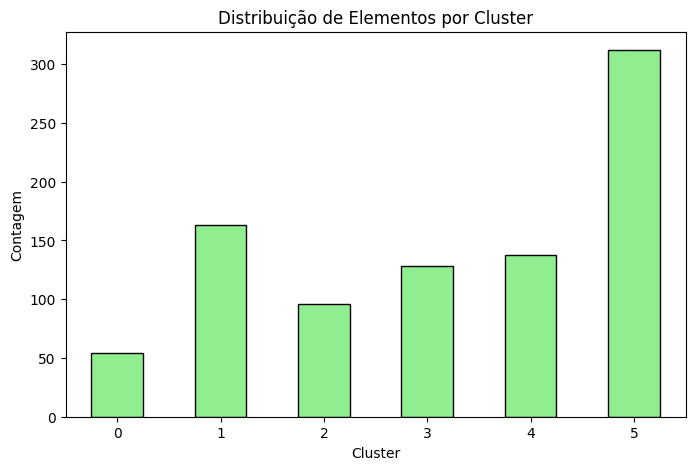


Distribuição da Pclass (%) em cada Cluster:


Pclass,1,2,3
Cluster_Final,,,
0,9.3,3.7,87.0
1,8.6,16.0,75.5
2,92.7,6.2,1.0
3,82.0,9.4,8.6
4,0.0,100.0,0.0
5,1.0,0.0,99.0



Distribuição do Sexo (%) em cada Cluster:


Sex,female,male
Cluster_Final,,
0,40.7,59.3
1,100.0,0.0
2,77.1,22.9
3,11.7,88.3
4,29.0,71.0
5,0.0,100.0



Distribuição de Embarked (%) em cada Cluster:


Embarked,C,Q,S
Cluster_Final,,,
0,0.0,9.3,90.7
1,14.1,19.6,66.3
2,75.0,1.0,24.0
3,15.6,3.1,81.2
4,7.2,1.4,91.3
5,13.8,10.6,75.6


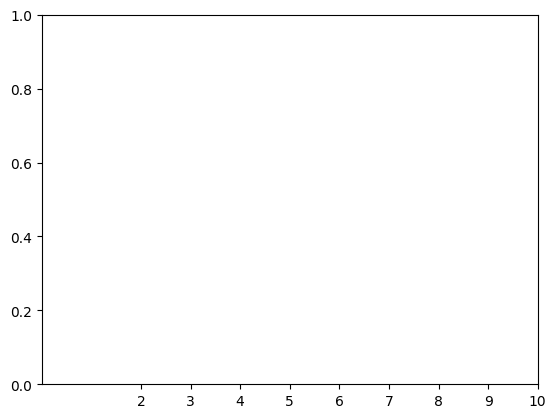

In [ ]:
# ==============================================================================
# 2. CÁLCULO DA MÉTRICA (ELBOW)
# ==============================================================================
print("\n" + "="*60)
print(f" CALCULANDO INÉRCIA PARA ELBOW METHOD")
print("="*60)

inertias = []
K_range = range(2, 11)

for k in K_range:
    # gamma=None deixa a biblioteca calcular automaticamente
    kproto = KPrototypes(n_clusters=k, n_init=10, random_state=42)
    kproto.fit(data_array, categorical=categorical_indices)

    inertias.append(kproto.cost_)

# ==============================================================================
# 3. LÓGICA DE SELEÇÃO: APENAS ELBOW (KNEED) E PLOTAGEM
# ==============================================================================

# A. Melhor K para Elbow (USANDO KNEED)
k_elbow_locator = KneeLocator(
    x=list(K_range),
    y=inertias,
    curve="convex",
    direction="decreasing"
)
best_k_elbow = k_elbow_locator.elbow

# Fallback
if best_k_elbow is None:
    best_k_elbow = 3

vencedor_k = best_k_elbow

print(f"\n>>> VALOR DE K ESCOLHIDO (ELBOW): {vencedor_k}")

# Plotagem Gráfica
plt.figure(figsize=(8, 6))
plt.plot(K_range, inertias, 'bo-')
plt.title(f'Elbow Method (Inércia) - K-Prototypes')
plt.xlabel('Número de Clusters (K)')
plt.ylabel('Custo/Inércia')

plt.xticks(K_range, rotation=0)

if vencedor_k:
    plt.axvline(x=vencedor_k, color='r', linestyle='--', label=f'K Escolhido: {vencedor_k}')
    plt.legend()

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# ==============================================================================
# 4. RODADA FINAL COM O K VENCEDOR
# ==============================================================================
print("\n" + "="*60)
print(f"EXECUTANDO K-PROTOTYPES FINAL COM K={vencedor_k}")
print("="*60)

model_final = KPrototypes(n_clusters=vencedor_k, n_init=100, random_state=42)
model_final.fit(data_array, categorical=categorical_indices)

# Adiciona o rótulo do cluster ao DataFrame
df_resultado = df_final.copy()
df_resultado['Cluster_Final'] = model_final.labels_

# --- NOVO REQUISITO: Imprimir contagem de elementos por cluster no console ---
print("\n--- QUANTIDADE DE ELEMENTOS POR CLUSTER ---")
counts = df_resultado['Cluster_Final'].value_counts().sort_index()
print(counts.to_string())
print("-" * 37)
# ----------------------------------------------------------------------------

# ==============================================================================
# 5. ANÁLISE DOS PROTÓTIPOS (CENTROIDES)
# ==============================================================================
print("\n--- ATRIBUTOS FINAIS ---")
print(f"Custo Final: {model_final.cost_:.4f}")
print(f"Gamma Final Usado: {model_final.gamma:.4f}") # Confirmação do gamma final

# A. Protótipos Numéricos
prototypes_num = model_final.cluster_centroids_[:, :len(numeric_cols)]
prototypes_num_df = pd.DataFrame(prototypes_num, columns=numeric_cols)

# B. Protótipos Categóricos
prototypes_cat = model_final.cluster_centroids_[:, len(numeric_cols):]
prototypes_cat_df = pd.DataFrame(prototypes_cat, columns=categorical_cols)

# C. Combinando e Exibindo
centroides_df = pd.concat([prototypes_num_df, prototypes_cat_df], axis=1)
centroides_df.index.name = 'Cluster'
print("\nProtótipos dos Clusters (Centroides e Modos):")
display(centroides_df)

# ==============================================================================
# 6. ANÁLISE DE DISTRIBUIÇÃO
# ==============================================================================

# Contagem (A contagem em console foi adicionada logo após o K-Prototypes final)
plt.figure(figsize=(8, 5))
counts.plot(kind='bar', color='lightgreen', edgecolor='black', rot=0) # rot=0 para garantir os rótulos retos
plt.title('Distribuição de Elementos por Cluster')
plt.xlabel('Cluster')
plt.ylabel('Contagem')
plt.show()

plt.xticks(K_range, rotation=0)

# Análise de Pclass
print("\nDistribuição da Pclass (%) em cada Cluster:")
pclass_by_cluster = pd.crosstab(df_resultado['Cluster_Final'], df_resultado['Pclass'], normalize='index') * 100
display(pclass_by_cluster.round(1))

# Análise de Sex
print("\nDistribuição do Sexo (%) em cada Cluster:")
sex_by_cluster = pd.crosstab(df_resultado['Cluster_Final'], df_resultado['Sex'], normalize='index') * 100
display(sex_by_cluster.round(1))

# Análise de Embarked
print("\nDistribuição de Embarked (%) em cada Cluster:")
embarked_by_cluster = pd.crosstab(df_resultado['Cluster_Final'], df_resultado['Embarked'], normalize='index') * 100
display(embarked_by_cluster.round(1))

# Análise de Cabin
# print("\nDistribuição de Cabin (%) em cada Cluster:")
# cabin_by_cluster = pd.crosstab(df_resultado['Cluster_Final'], df_resultado['Cabin'], normalize='index') * 100
# display(cabin_by_cluster.round(1))


 ANÁLISE NUMÉRICA DETALHADA (VALORES ORIGINAIS)

>>> Média das Variáveis por Cluster (Escala Real):


,Age,Fare,Family
Cluster_Final,,,
0,16.22,53.94,5.87
1,22.08,19.83,1.14
2,31.88,111.33,0.79
3,47.10,44.65,0.49
4,30.19,19.62,0.55
5,27.02,11.02,0.28



>>> Mediana das Variáveis por Cluster (Escala Real) - (Mais robusto a outliers):


,Age,Fare,Family
Cluster_Final,,,
0,11.0,31.39,5.0
1,24.0,14.46,1.0
2,30.0,83.16,1.0
3,48.0,30.60,0.0
4,30.0,13.00,0.0
5,28.0,7.90,0.0



>>> Distribuição Visual (Boxplots):


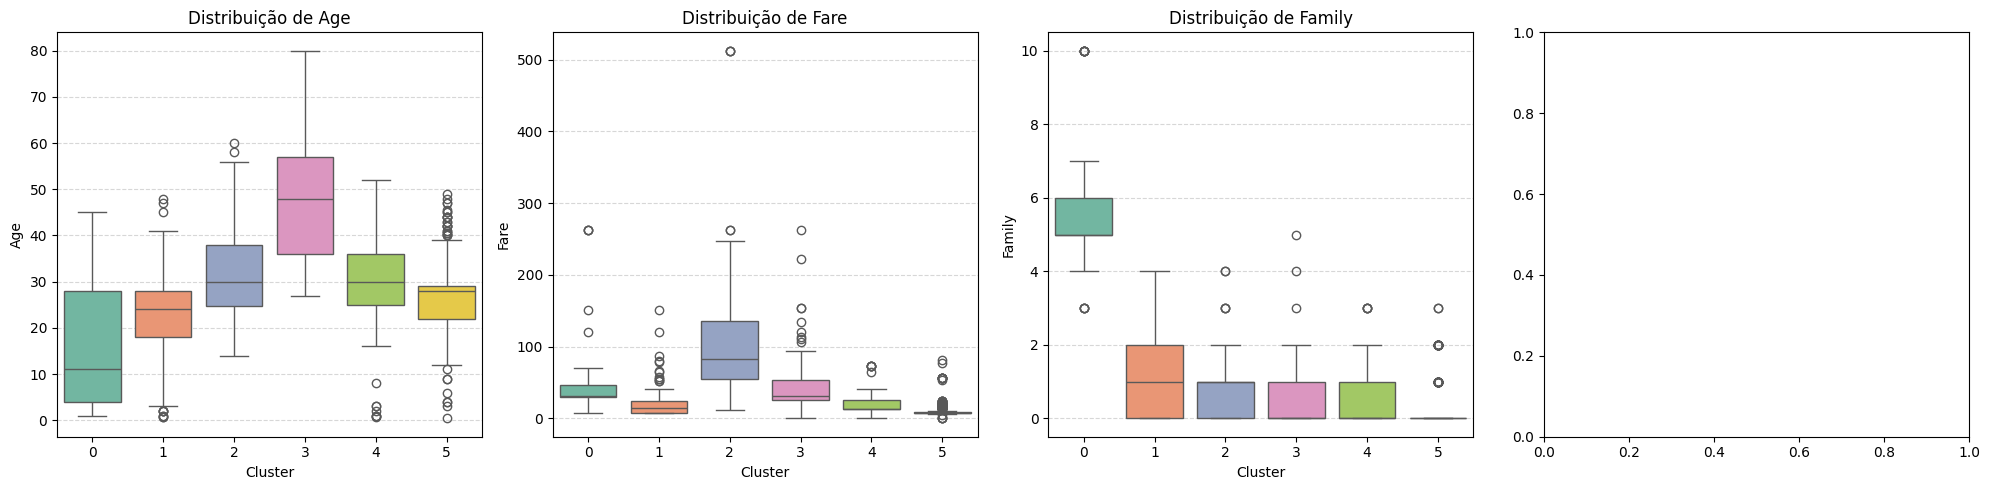

In [ ]:
# ==============================================================================
# 7. ANÁLISE DAS VARIÁVEIS NUMÉRICAS (ESCALA ORIGINAL)
# ==============================================================================
print("\n" + "="*60)
print(" ANÁLISE NUMÉRICA DETALHADA (VALORES ORIGINAIS)")
print("="*60)

# Limpa qualquer gráfico "fantasma" que tenha ficado na memória
plt.close('all')

# 1. Recuperamos os dados originais (antes da normalização)
df_analysis = df[numeric_cols].copy()
df_analysis['Cluster_Final'] = model_final.labels_

# ------------------------------------------------------------------------------
# A. TABELA DE MÉDIAS E MEDIANAS
# ------------------------------------------------------------------------------
print("\n>>> Média das Variáveis por Cluster (Escala Real):")
numeric_means = df_analysis.groupby('Cluster_Final')[numeric_cols].mean()
display(numeric_means.round(2))

print("\n>>> Mediana das Variáveis por Cluster (Escala Real) - (Mais robusto a outliers):")
numeric_medians = df_analysis.groupby('Cluster_Final')[numeric_cols].median()
display(numeric_medians.round(2))

# ------------------------------------------------------------------------------
# B. VISUALIZAÇÃO COM BOXPLOTS
# ------------------------------------------------------------------------------
print("\n>>> Distribuição Visual (Boxplots):")

# Configura o tamanho da figura
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# Cores
palette = sns.color_palette("Set2", n_colors=vencedor_k)

for i, col in enumerate(numeric_cols):
    # AJUSTE AQUI: Adicionado hue=... e legend=False para corrigir o Warning e garantir a cor correta
    sns.boxplot(
        x='Cluster_Final',
        y=col,
        data=df_analysis,
        ax=axes[i],
        palette=palette,
        hue='Cluster_Final',
        legend=False
    )

    axes[i].set_title(f'Distribuição de {col}', fontsize=12)
    axes[i].set_xlabel('Cluster')
    axes[i].set_ylabel(col)
    axes[i].grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

# ------------------------------------------------------------------------------
# C. INTERPRETAÇÃO AUTOMÁTICA SIMPLES
# ------------------------------------------------------------------------------
# print("\n--- RESUMO RÁPIDO ---")
# Recalcula counts caso não esteja na memória
#c ounts = df_analysis['Cluster_Final'].value_counts().sort_index()

# for cluster_id in range(vencedor_k):
#     n_elem = counts[cluster_id]
#    avg_age = numeric_means.loc[cluster_id, 'Age']
#    avg_fare = numeric_means.loc[cluster_id, 'Fare']
#    print(f"Cluster {cluster_id} ({n_elem} pessoas): Média Idade={avg_age:.1f} anos | Média Tarifa=${avg_fare:.2f}")'''